In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "full"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 0
Categorical features: 0
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 660
Categorical Columns: 10


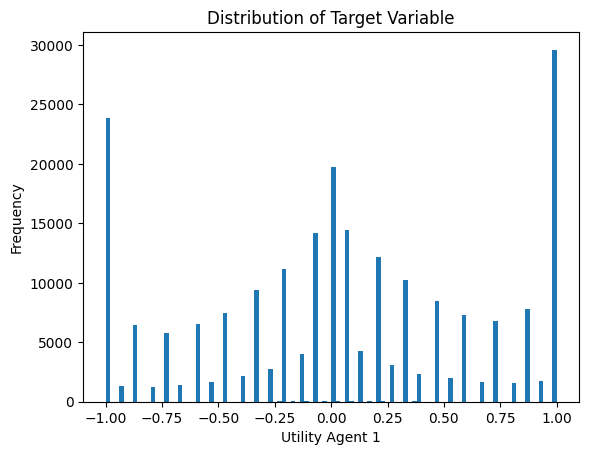

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.500826


[200]	valid_0's rmse: 0.483677


[300]	valid_0's rmse: 0.474102


[400]	valid_0's rmse: 0.467633


[500]	valid_0's rmse: 0.462673


[600]	valid_0's rmse: 0.459001


[700]	valid_0's rmse: 0.455369


[800]	valid_0's rmse: 0.452873


[900]	valid_0's rmse: 0.450072


[1000]	valid_0's rmse: 0.447516


[1100]	valid_0's rmse: 0.445747


[1200]	valid_0's rmse: 0.444492


[1300]	valid_0's rmse: 0.443342


[1400]	valid_0's rmse: 0.442125


[1500]	valid_0's rmse: 0.441284


[1600]	valid_0's rmse: 0.440656


[1700]	valid_0's rmse: 0.440019


[1800]	valid_0's rmse: 0.439402


[1900]	valid_0's rmse: 0.438761


[2000]	valid_0's rmse: 0.438203


[2100]	valid_0's rmse: 0.437728


[2200]	valid_0's rmse: 0.437275


[2300]	valid_0's rmse: 0.436935


[2400]	valid_0's rmse: 0.436704


[2500]	valid_0's rmse: 0.436398


[2600]	valid_0's rmse: 0.436056


[2700]	valid_0's rmse: 0.43585


[2800]	valid_0's rmse: 0.435708


[2900]	valid_0's rmse: 0.435402


[3000]	valid_0's rmse: 0.435212


[3100]	valid_0's rmse: 0.434953


[3200]	valid_0's rmse: 0.434706


[3300]	valid_0's rmse: 0.434499


[3400]	valid_0's rmse: 0.434325


[3500]	valid_0's rmse: 0.434087


[3600]	valid_0's rmse: 0.433977


[3700]	valid_0's rmse: 0.433815


[3800]	valid_0's rmse: 0.433625


[3900]	valid_0's rmse: 0.433386


[4000]	valid_0's rmse: 0.433251


[4100]	valid_0's rmse: 0.433115


[4200]	valid_0's rmse: 0.432946


[4300]	valid_0's rmse: 0.432859


[4400]	valid_0's rmse: 0.432802


[4500]	valid_0's rmse: 0.432742


[4600]	valid_0's rmse: 0.432611


[4700]	valid_0's rmse: 0.432562


[4800]	valid_0's rmse: 0.432514


[4900]	valid_0's rmse: 0.432369


[5000]	valid_0's rmse: 0.432332


[5100]	valid_0's rmse: 0.432164


[5200]	valid_0's rmse: 0.432013


[5300]	valid_0's rmse: 0.431868


[5400]	valid_0's rmse: 0.43176


[5500]	valid_0's rmse: 0.431726


[5600]	valid_0's rmse: 0.431712


[5700]	valid_0's rmse: 0.431713


[5800]	valid_0's rmse: 0.431685


[5900]	valid_0's rmse: 0.431616


[6000]	valid_0's rmse: 0.431632


[6100]	valid_0's rmse: 0.431582


[6200]	valid_0's rmse: 0.431527


[6300]	valid_0's rmse: 0.431459


[6400]	valid_0's rmse: 0.431308


[6500]	valid_0's rmse: 0.431335


[6600]	valid_0's rmse: 0.431229


[6700]	valid_0's rmse: 0.431186


[6800]	valid_0's rmse: 0.431166


[6900]	valid_0's rmse: 0.431151


[7000]	valid_0's rmse: 0.431134


[7100]	valid_0's rmse: 0.43108


[7200]	valid_0's rmse: 0.431041


[7300]	valid_0's rmse: 0.431056


[7400]	valid_0's rmse: 0.431057


[7500]	valid_0's rmse: 0.431118


[7600]	valid_0's rmse: 0.431024


[7700]	valid_0's rmse: 0.431011


[7800]	valid_0's rmse: 0.430944


[7900]	valid_0's rmse: 0.430977


[8000]	valid_0's rmse: 0.430923


[8100]	valid_0's rmse: 0.430941


[8200]	valid_0's rmse: 0.430946


[8300]	valid_0's rmse: 0.430891


[8400]	valid_0's rmse: 0.430858


[8500]	valid_0's rmse: 0.430913


[8600]	valid_0's rmse: 0.430871


[8700]	valid_0's rmse: 0.430857


[8800]	valid_0's rmse: 0.430799


[8900]	valid_0's rmse: 0.430774


[9000]	valid_0's rmse: 0.430744


[9100]	valid_0's rmse: 0.430696


[9200]	valid_0's rmse: 0.430669


[9300]	valid_0's rmse: 0.430693


[9400]	valid_0's rmse: 0.430703


[9500]	valid_0's rmse: 0.430683


[9600]	valid_0's rmse: 0.430677


[9700]	valid_0's rmse: 0.430656


[9800]	valid_0's rmse: 0.430621


[9900]	valid_0's rmse: 0.430604


[10000]	valid_0's rmse: 0.430606


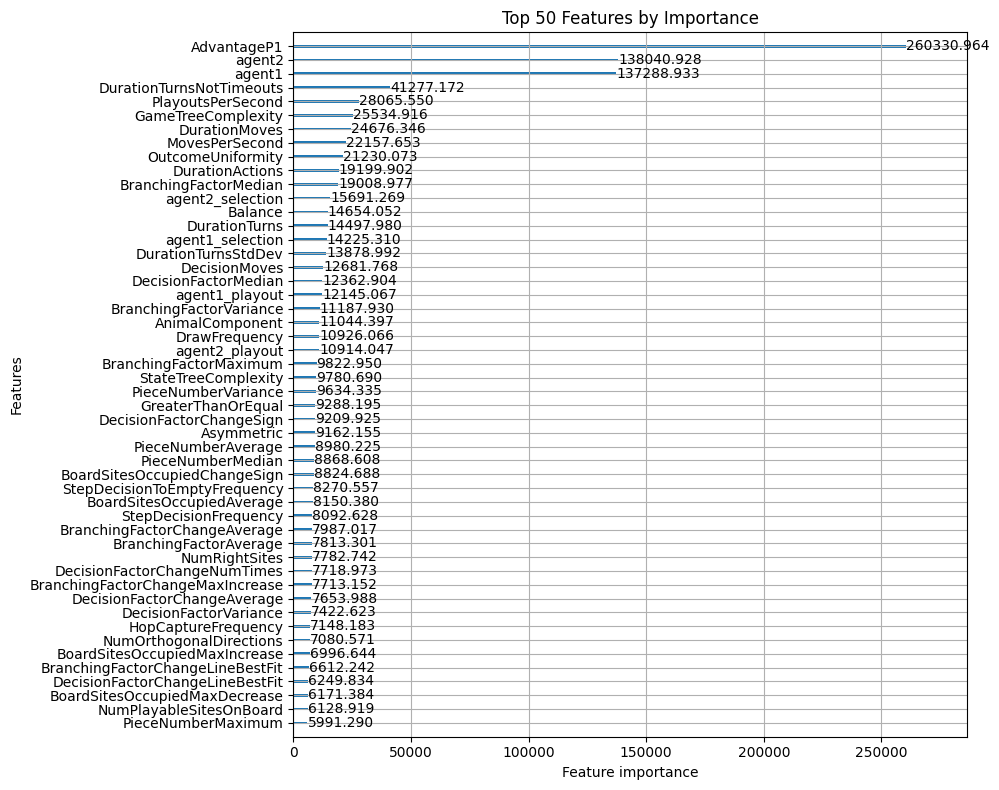

Fold 1 - RMSE: 0.43018518400035455
Fold 2


[100]	valid_0's rmse: 0.51119


[200]	valid_0's rmse: 0.494027


[300]	valid_0's rmse: 0.486646


[400]	valid_0's rmse: 0.481105


[500]	valid_0's rmse: 0.478125


[600]	valid_0's rmse: 0.47467


[700]	valid_0's rmse: 0.47327


[800]	valid_0's rmse: 0.471286


[900]	valid_0's rmse: 0.469854


[1000]	valid_0's rmse: 0.468687


[1100]	valid_0's rmse: 0.467701


[1200]	valid_0's rmse: 0.466565


[1300]	valid_0's rmse: 0.465645


[1400]	valid_0's rmse: 0.464986


[1500]	valid_0's rmse: 0.464281


[1600]	valid_0's rmse: 0.463701


[1700]	valid_0's rmse: 0.463047


[1800]	valid_0's rmse: 0.462394


[1900]	valid_0's rmse: 0.461791


[2000]	valid_0's rmse: 0.461262


[2100]	valid_0's rmse: 0.460859


[2200]	valid_0's rmse: 0.460542


[2300]	valid_0's rmse: 0.460092


[2400]	valid_0's rmse: 0.459605


[2500]	valid_0's rmse: 0.459383


[2600]	valid_0's rmse: 0.459171


[2700]	valid_0's rmse: 0.458866


[2800]	valid_0's rmse: 0.458489


[2900]	valid_0's rmse: 0.458161


[3000]	valid_0's rmse: 0.457958


[3100]	valid_0's rmse: 0.457718


[3200]	valid_0's rmse: 0.457581


[3300]	valid_0's rmse: 0.457441


[3400]	valid_0's rmse: 0.457239


[3500]	valid_0's rmse: 0.457158


[3600]	valid_0's rmse: 0.456987


[3700]	valid_0's rmse: 0.456919


[3800]	valid_0's rmse: 0.456745


[3900]	valid_0's rmse: 0.456576


[4000]	valid_0's rmse: 0.456396


[4100]	valid_0's rmse: 0.456262


[4200]	valid_0's rmse: 0.456151


[4300]	valid_0's rmse: 0.456191


[4400]	valid_0's rmse: 0.456068


[4500]	valid_0's rmse: 0.456016


[4600]	valid_0's rmse: 0.455877


[4700]	valid_0's rmse: 0.455698


[4800]	valid_0's rmse: 0.45558


[4900]	valid_0's rmse: 0.45538


[5000]	valid_0's rmse: 0.455288


[5100]	valid_0's rmse: 0.455214


[5200]	valid_0's rmse: 0.455177


[5300]	valid_0's rmse: 0.45502


[5400]	valid_0's rmse: 0.455051


[5500]	valid_0's rmse: 0.454932


[5600]	valid_0's rmse: 0.454859


[5700]	valid_0's rmse: 0.454831


[5800]	valid_0's rmse: 0.454766


[5900]	valid_0's rmse: 0.454608


[6000]	valid_0's rmse: 0.454542


[6100]	valid_0's rmse: 0.454441


[6200]	valid_0's rmse: 0.45444


[6300]	valid_0's rmse: 0.454383


[6400]	valid_0's rmse: 0.454416


[6500]	valid_0's rmse: 0.454311


[6600]	valid_0's rmse: 0.45426


[6700]	valid_0's rmse: 0.454318


[6800]	valid_0's rmse: 0.454314


[6900]	valid_0's rmse: 0.454308


[7000]	valid_0's rmse: 0.454203


[7100]	valid_0's rmse: 0.454172


[7200]	valid_0's rmse: 0.454157


[7300]	valid_0's rmse: 0.454101


[7400]	valid_0's rmse: 0.453987


[7500]	valid_0's rmse: 0.454019


[7600]	valid_0's rmse: 0.453986


[7700]	valid_0's rmse: 0.453978


[7800]	valid_0's rmse: 0.453955


[7900]	valid_0's rmse: 0.453922


[8000]	valid_0's rmse: 0.453926


[8100]	valid_0's rmse: 0.453817


[8200]	valid_0's rmse: 0.453746


[8300]	valid_0's rmse: 0.45367


[8400]	valid_0's rmse: 0.453624


[8500]	valid_0's rmse: 0.453543


[8600]	valid_0's rmse: 0.45349


[8700]	valid_0's rmse: 0.453503


[8800]	valid_0's rmse: 0.453462


[8900]	valid_0's rmse: 0.45341


[9000]	valid_0's rmse: 0.453408


[9100]	valid_0's rmse: 0.45335


[9200]	valid_0's rmse: 0.45335


[9300]	valid_0's rmse: 0.45329


[9400]	valid_0's rmse: 0.453318


[9500]	valid_0's rmse: 0.453287


[9600]	valid_0's rmse: 0.453307


[9700]	valid_0's rmse: 0.453306


[9800]	valid_0's rmse: 0.453316


[9900]	valid_0's rmse: 0.453287


[10000]	valid_0's rmse: 0.453281


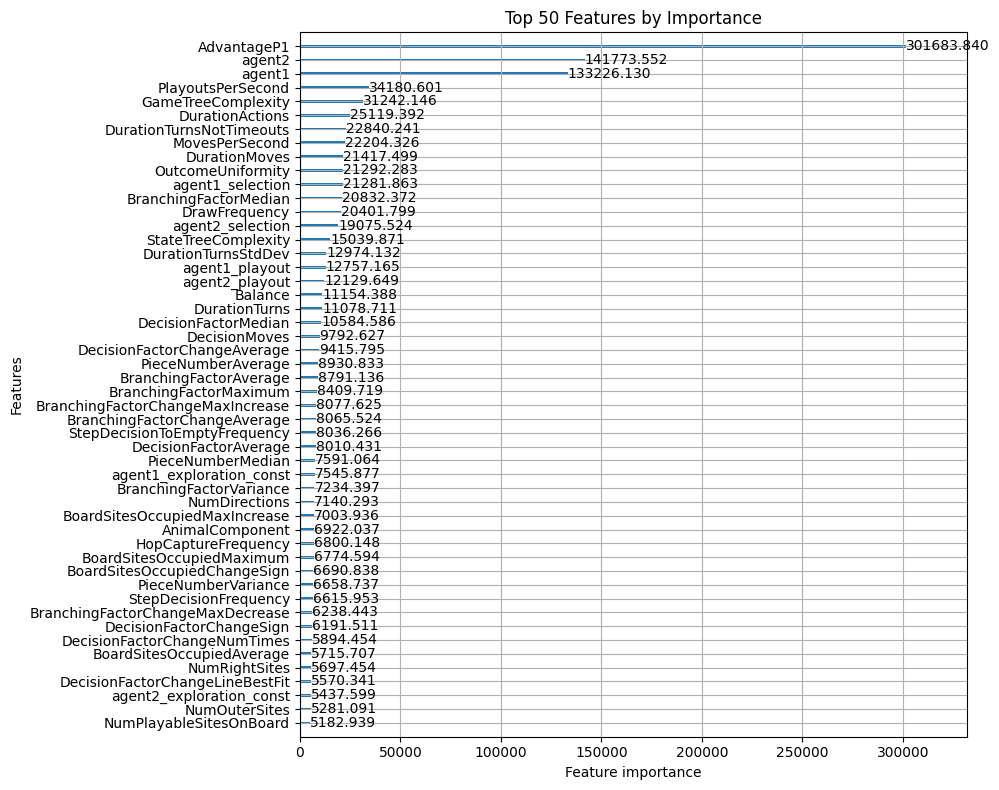

Fold 2 - RMSE: 0.4526232085403121
Fold 3


[100]	valid_0's rmse: 0.514974


[200]	valid_0's rmse: 0.487583


[300]	valid_0's rmse: 0.475891


[400]	valid_0's rmse: 0.469255


[500]	valid_0's rmse: 0.465355


[600]	valid_0's rmse: 0.46203


[700]	valid_0's rmse: 0.459087


[800]	valid_0's rmse: 0.456815


[900]	valid_0's rmse: 0.454833


[1000]	valid_0's rmse: 0.453314


[1100]	valid_0's rmse: 0.452191


[1200]	valid_0's rmse: 0.450906


[1300]	valid_0's rmse: 0.449863


[1400]	valid_0's rmse: 0.448938


[1500]	valid_0's rmse: 0.448225


[1600]	valid_0's rmse: 0.447512


[1700]	valid_0's rmse: 0.447043


[1800]	valid_0's rmse: 0.446575


[1900]	valid_0's rmse: 0.446


[2000]	valid_0's rmse: 0.445541


[2100]	valid_0's rmse: 0.445211


[2200]	valid_0's rmse: 0.444894


[2300]	valid_0's rmse: 0.444496


[2400]	valid_0's rmse: 0.444242


[2500]	valid_0's rmse: 0.443919


[2600]	valid_0's rmse: 0.443612


[2700]	valid_0's rmse: 0.443376


[2800]	valid_0's rmse: 0.443001


[2900]	valid_0's rmse: 0.442837


[3000]	valid_0's rmse: 0.442672


[3100]	valid_0's rmse: 0.442389


[3200]	valid_0's rmse: 0.442291


[3300]	valid_0's rmse: 0.442116


[3400]	valid_0's rmse: 0.441902


[3500]	valid_0's rmse: 0.44171


[3600]	valid_0's rmse: 0.4416


[3700]	valid_0's rmse: 0.441517


[3800]	valid_0's rmse: 0.441396


[3900]	valid_0's rmse: 0.441269


[4000]	valid_0's rmse: 0.441171


[4100]	valid_0's rmse: 0.441105


[4200]	valid_0's rmse: 0.441088


[4300]	valid_0's rmse: 0.440936


[4400]	valid_0's rmse: 0.440814


[4500]	valid_0's rmse: 0.440705


[4600]	valid_0's rmse: 0.440576


[4700]	valid_0's rmse: 0.440456


[4800]	valid_0's rmse: 0.440348


[4900]	valid_0's rmse: 0.440173


[5000]	valid_0's rmse: 0.440096


[5100]	valid_0's rmse: 0.440115


[5200]	valid_0's rmse: 0.440024


[5300]	valid_0's rmse: 0.43989


[5400]	valid_0's rmse: 0.439853


[5500]	valid_0's rmse: 0.43981


[5600]	valid_0's rmse: 0.439757


[5700]	valid_0's rmse: 0.439687


[5800]	valid_0's rmse: 0.439659


[5900]	valid_0's rmse: 0.439602


[6000]	valid_0's rmse: 0.439476


[6100]	valid_0's rmse: 0.439468


[6200]	valid_0's rmse: 0.439424


[6300]	valid_0's rmse: 0.439345


[6400]	valid_0's rmse: 0.439306


[6500]	valid_0's rmse: 0.439266


[6600]	valid_0's rmse: 0.439161


[6700]	valid_0's rmse: 0.439079


[6800]	valid_0's rmse: 0.439056


[6900]	valid_0's rmse: 0.43906


[7000]	valid_0's rmse: 0.439068


[7100]	valid_0's rmse: 0.439085


[7200]	valid_0's rmse: 0.438991


[7300]	valid_0's rmse: 0.438959


[7400]	valid_0's rmse: 0.43887


[7500]	valid_0's rmse: 0.43885


[7600]	valid_0's rmse: 0.43878


[7700]	valid_0's rmse: 0.43879


[7800]	valid_0's rmse: 0.438762


[7900]	valid_0's rmse: 0.438702


[8000]	valid_0's rmse: 0.438667


[8100]	valid_0's rmse: 0.438603


[8200]	valid_0's rmse: 0.438553


[8300]	valid_0's rmse: 0.438502


[8400]	valid_0's rmse: 0.438481


[8500]	valid_0's rmse: 0.438471


[8600]	valid_0's rmse: 0.438457


[8700]	valid_0's rmse: 0.438425


[8800]	valid_0's rmse: 0.438447


[8900]	valid_0's rmse: 0.438378


[9000]	valid_0's rmse: 0.438385


[9100]	valid_0's rmse: 0.438406


[9200]	valid_0's rmse: 0.438418


[9300]	valid_0's rmse: 0.438409


[9400]	valid_0's rmse: 0.438395


[9500]	valid_0's rmse: 0.438421


[9600]	valid_0's rmse: 0.438337


[9700]	valid_0's rmse: 0.438352


[9800]	valid_0's rmse: 0.438341


[9900]	valid_0's rmse: 0.438367


[10000]	valid_0's rmse: 0.438433


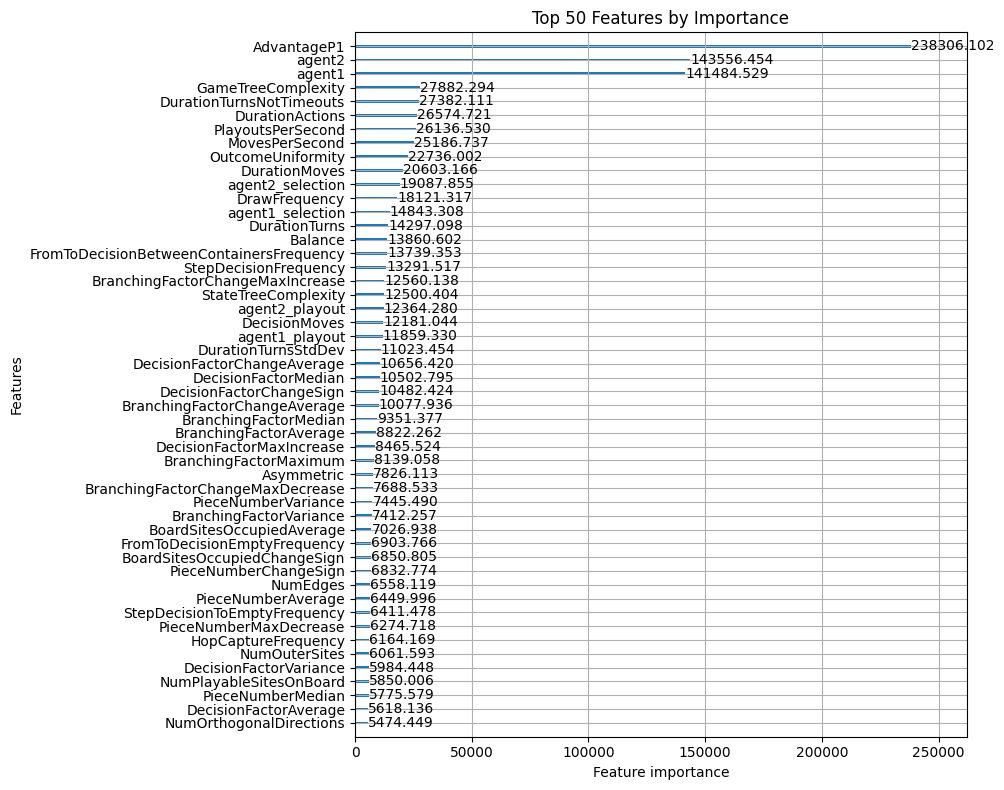

Fold 3 - RMSE: 0.43775849038090225
Fold 4


[100]	valid_0's rmse: 0.518095


[200]	valid_0's rmse: 0.495301


[300]	valid_0's rmse: 0.484209


[400]	valid_0's rmse: 0.475927


[500]	valid_0's rmse: 0.469807


[600]	valid_0's rmse: 0.466052


[700]	valid_0's rmse: 0.462993


[800]	valid_0's rmse: 0.460581


[900]	valid_0's rmse: 0.458693


[1000]	valid_0's rmse: 0.45697


[1100]	valid_0's rmse: 0.455377


[1200]	valid_0's rmse: 0.454073


[1300]	valid_0's rmse: 0.453058


[1400]	valid_0's rmse: 0.452087


[1500]	valid_0's rmse: 0.451389


[1600]	valid_0's rmse: 0.450447


[1700]	valid_0's rmse: 0.449688


[1800]	valid_0's rmse: 0.448844


[1900]	valid_0's rmse: 0.448298


[2000]	valid_0's rmse: 0.447762


[2100]	valid_0's rmse: 0.44741


[2200]	valid_0's rmse: 0.447022


[2300]	valid_0's rmse: 0.446512


[2400]	valid_0's rmse: 0.44612


[2500]	valid_0's rmse: 0.445848


[2600]	valid_0's rmse: 0.445433


[2700]	valid_0's rmse: 0.445163


[2800]	valid_0's rmse: 0.444751


[2900]	valid_0's rmse: 0.444526


[3000]	valid_0's rmse: 0.444365


[3100]	valid_0's rmse: 0.444036


[3200]	valid_0's rmse: 0.443859


[3300]	valid_0's rmse: 0.443568


[3400]	valid_0's rmse: 0.443374


[3500]	valid_0's rmse: 0.443083


[3600]	valid_0's rmse: 0.442802


[3700]	valid_0's rmse: 0.442687


[3800]	valid_0's rmse: 0.442492


[3900]	valid_0's rmse: 0.442229


[4000]	valid_0's rmse: 0.442037


[4100]	valid_0's rmse: 0.441873


[4200]	valid_0's rmse: 0.44166


[4300]	valid_0's rmse: 0.441504


[4400]	valid_0's rmse: 0.441384


[4500]	valid_0's rmse: 0.441241


[4600]	valid_0's rmse: 0.441061


[4700]	valid_0's rmse: 0.440883


[4800]	valid_0's rmse: 0.440656


[4900]	valid_0's rmse: 0.440495


[5000]	valid_0's rmse: 0.440297


[5100]	valid_0's rmse: 0.440178


[5200]	valid_0's rmse: 0.440187


[5300]	valid_0's rmse: 0.440058


[5400]	valid_0's rmse: 0.439936


[5500]	valid_0's rmse: 0.43992


[5600]	valid_0's rmse: 0.439885


[5700]	valid_0's rmse: 0.439762


[5800]	valid_0's rmse: 0.439759


[5900]	valid_0's rmse: 0.439623


[6000]	valid_0's rmse: 0.439581


[6100]	valid_0's rmse: 0.4395


[6200]	valid_0's rmse: 0.439424


[6300]	valid_0's rmse: 0.439387


[6400]	valid_0's rmse: 0.439293


[6500]	valid_0's rmse: 0.439259


[6600]	valid_0's rmse: 0.439208


[6700]	valid_0's rmse: 0.439131


[6800]	valid_0's rmse: 0.439074


[6900]	valid_0's rmse: 0.439013


[7000]	valid_0's rmse: 0.438923


[7100]	valid_0's rmse: 0.438852


[7200]	valid_0's rmse: 0.438805


[7300]	valid_0's rmse: 0.43878


[7400]	valid_0's rmse: 0.438808


[7500]	valid_0's rmse: 0.438816


[7600]	valid_0's rmse: 0.438702


[7700]	valid_0's rmse: 0.438722


[7800]	valid_0's rmse: 0.438666


[7900]	valid_0's rmse: 0.438605


[8000]	valid_0's rmse: 0.438565


[8100]	valid_0's rmse: 0.438539


[8200]	valid_0's rmse: 0.438506


[8300]	valid_0's rmse: 0.438508


[8400]	valid_0's rmse: 0.438533


[8500]	valid_0's rmse: 0.438475


[8600]	valid_0's rmse: 0.438484


[8700]	valid_0's rmse: 0.438445


[8800]	valid_0's rmse: 0.438476


[8900]	valid_0's rmse: 0.438485


[9000]	valid_0's rmse: 0.438458


[9100]	valid_0's rmse: 0.43845


[9200]	valid_0's rmse: 0.438399


[9300]	valid_0's rmse: 0.438365


[9400]	valid_0's rmse: 0.438374


[9500]	valid_0's rmse: 0.438358


[9600]	valid_0's rmse: 0.438392


[9700]	valid_0's rmse: 0.438391


[9800]	valid_0's rmse: 0.438397


[9900]	valid_0's rmse: 0.438405


[10000]	valid_0's rmse: 0.438381


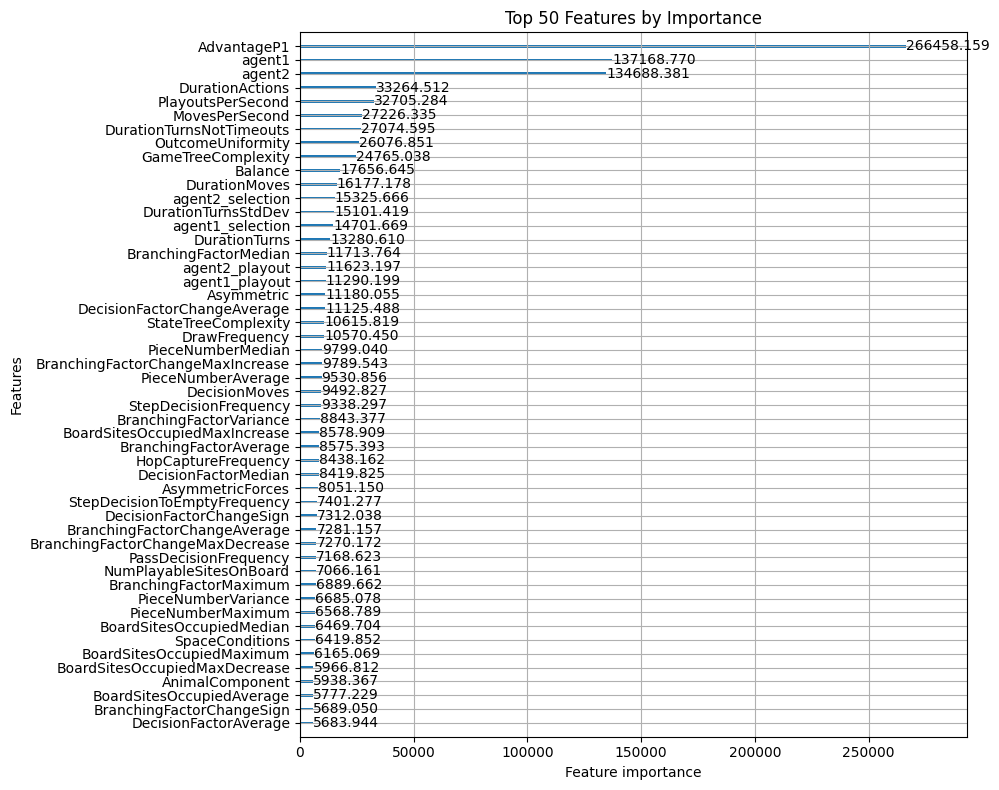

Fold 4 - RMSE: 0.4374785703033493
Fold 5


[100]	valid_0's rmse: 0.491952


[200]	valid_0's rmse: 0.469437


[300]	valid_0's rmse: 0.456549


[400]	valid_0's rmse: 0.448663


[500]	valid_0's rmse: 0.443044


[600]	valid_0's rmse: 0.439292


[700]	valid_0's rmse: 0.435776


[800]	valid_0's rmse: 0.43247


[900]	valid_0's rmse: 0.429937


[1000]	valid_0's rmse: 0.427742


[1100]	valid_0's rmse: 0.426078


[1200]	valid_0's rmse: 0.424601


[1300]	valid_0's rmse: 0.42335


[1400]	valid_0's rmse: 0.422102


[1500]	valid_0's rmse: 0.420888


[1600]	valid_0's rmse: 0.419997


[1700]	valid_0's rmse: 0.419233


[1800]	valid_0's rmse: 0.41855


[1900]	valid_0's rmse: 0.417791


[2000]	valid_0's rmse: 0.417293


[2100]	valid_0's rmse: 0.416721


[2200]	valid_0's rmse: 0.416183


[2300]	valid_0's rmse: 0.415636


[2400]	valid_0's rmse: 0.415274


[2500]	valid_0's rmse: 0.414922


[2600]	valid_0's rmse: 0.414691


[2700]	valid_0's rmse: 0.414389


[2800]	valid_0's rmse: 0.413993


[2900]	valid_0's rmse: 0.413684


[3000]	valid_0's rmse: 0.413396


[3100]	valid_0's rmse: 0.413092


[3200]	valid_0's rmse: 0.412913


[3300]	valid_0's rmse: 0.412674


[3400]	valid_0's rmse: 0.412561


[3500]	valid_0's rmse: 0.412266


[3600]	valid_0's rmse: 0.412114


[3700]	valid_0's rmse: 0.411926


[3800]	valid_0's rmse: 0.411855


[3900]	valid_0's rmse: 0.411636


[4000]	valid_0's rmse: 0.411511


[4100]	valid_0's rmse: 0.411392


[4200]	valid_0's rmse: 0.411299


[4300]	valid_0's rmse: 0.411187


[4400]	valid_0's rmse: 0.411138


[4500]	valid_0's rmse: 0.410965


[4600]	valid_0's rmse: 0.410868


[4700]	valid_0's rmse: 0.410755


[4800]	valid_0's rmse: 0.41056


[4900]	valid_0's rmse: 0.410506


[5000]	valid_0's rmse: 0.41045


[5100]	valid_0's rmse: 0.410391


[5200]	valid_0's rmse: 0.410323


[5300]	valid_0's rmse: 0.410217


[5400]	valid_0's rmse: 0.410206


[5500]	valid_0's rmse: 0.410127


[5600]	valid_0's rmse: 0.410115


[5700]	valid_0's rmse: 0.410109


[5800]	valid_0's rmse: 0.409959


[5900]	valid_0's rmse: 0.409915


[6000]	valid_0's rmse: 0.40979


[6100]	valid_0's rmse: 0.409733


[6200]	valid_0's rmse: 0.409641


[6300]	valid_0's rmse: 0.409661


[6400]	valid_0's rmse: 0.409592


[6500]	valid_0's rmse: 0.409493


[6600]	valid_0's rmse: 0.409397


[6700]	valid_0's rmse: 0.409301


[6800]	valid_0's rmse: 0.409265


[6900]	valid_0's rmse: 0.409253


[7000]	valid_0's rmse: 0.409238


[7100]	valid_0's rmse: 0.409225


[7200]	valid_0's rmse: 0.409181


[7300]	valid_0's rmse: 0.40914


[7400]	valid_0's rmse: 0.40912


[7500]	valid_0's rmse: 0.409111


[7600]	valid_0's rmse: 0.409081


[7700]	valid_0's rmse: 0.40913


[7800]	valid_0's rmse: 0.409091


[7900]	valid_0's rmse: 0.409153


[8000]	valid_0's rmse: 0.409106


[8100]	valid_0's rmse: 0.40915


[8200]	valid_0's rmse: 0.409059


[8300]	valid_0's rmse: 0.409075


[8400]	valid_0's rmse: 0.409035


[8500]	valid_0's rmse: 0.409029


[8600]	valid_0's rmse: 0.408986


[8700]	valid_0's rmse: 0.408963


[8800]	valid_0's rmse: 0.408936


[8900]	valid_0's rmse: 0.408922


[9000]	valid_0's rmse: 0.40895


[9100]	valid_0's rmse: 0.408897


[9200]	valid_0's rmse: 0.408866


[9300]	valid_0's rmse: 0.408855


[9400]	valid_0's rmse: 0.408803


[9500]	valid_0's rmse: 0.408784


[9600]	valid_0's rmse: 0.408801


[9700]	valid_0's rmse: 0.408762


[9800]	valid_0's rmse: 0.408724


[9900]	valid_0's rmse: 0.408656


[10000]	valid_0's rmse: 0.408679


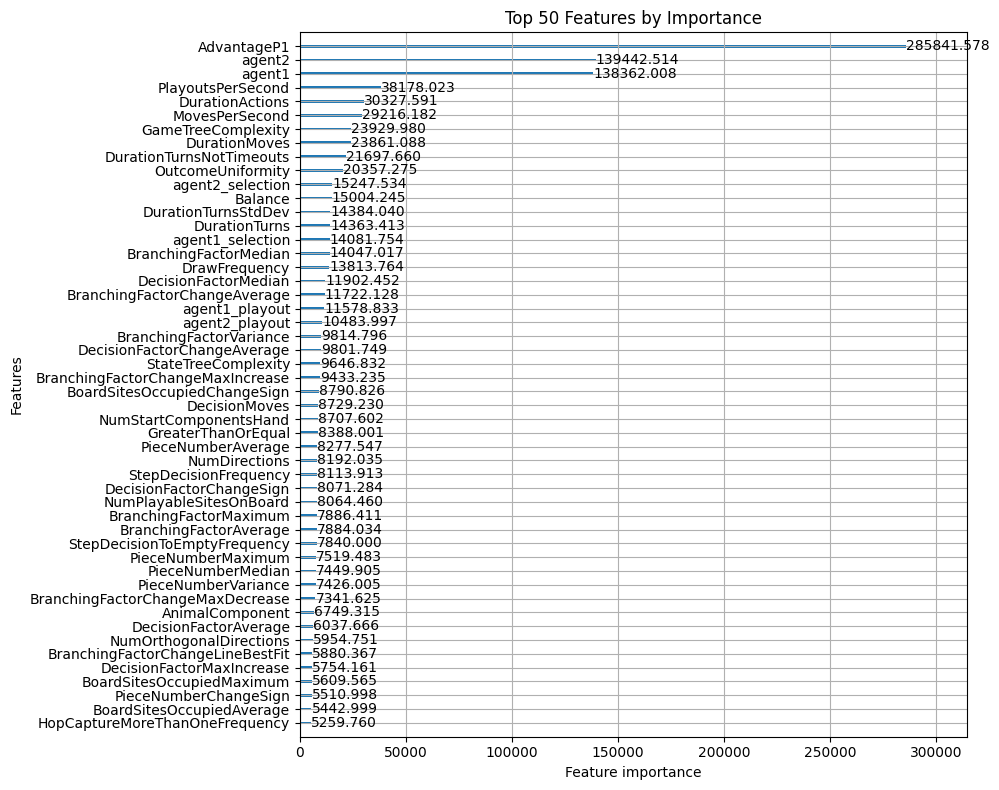

Fold 5 - RMSE: 0.40829753290615967
List of oof scores: [0.43018518400035455, 0.4526232085403121, 0.43775849038090225, 0.4374785703033493, 0.40829753290615967]
Average oof score: 0.4332685972262156


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.478853


[200]	valid_0's rmse: 0.459804


[300]	valid_0's rmse: 0.449855


[400]	valid_0's rmse: 0.444176


[500]	valid_0's rmse: 0.44068


[600]	valid_0's rmse: 0.43766


[700]	valid_0's rmse: 0.435454


[800]	valid_0's rmse: 0.433507


[900]	valid_0's rmse: 0.431845


[1000]	valid_0's rmse: 0.430299


[1100]	valid_0's rmse: 0.428958


[1200]	valid_0's rmse: 0.427896


[1300]	valid_0's rmse: 0.427146


[1400]	valid_0's rmse: 0.426412


[1500]	valid_0's rmse: 0.425644


[1600]	valid_0's rmse: 0.424965


[1700]	valid_0's rmse: 0.424361


[1800]	valid_0's rmse: 0.423929


[1900]	valid_0's rmse: 0.423298


[2000]	valid_0's rmse: 0.422953


[2100]	valid_0's rmse: 0.422478


[2200]	valid_0's rmse: 0.422058


[2300]	valid_0's rmse: 0.421537


[2400]	valid_0's rmse: 0.421311


[2500]	valid_0's rmse: 0.421047


[2600]	valid_0's rmse: 0.420652


[2700]	valid_0's rmse: 0.420265


[2800]	valid_0's rmse: 0.420067


[2900]	valid_0's rmse: 0.419823


[3000]	valid_0's rmse: 0.419477


[3100]	valid_0's rmse: 0.419253


[3200]	valid_0's rmse: 0.419096


[3300]	valid_0's rmse: 0.418813


[3400]	valid_0's rmse: 0.4186


[3500]	valid_0's rmse: 0.418502


[3600]	valid_0's rmse: 0.418373


[3700]	valid_0's rmse: 0.418157


[3800]	valid_0's rmse: 0.418023


[3900]	valid_0's rmse: 0.417863


[4000]	valid_0's rmse: 0.417699


[4100]	valid_0's rmse: 0.417506


[4200]	valid_0's rmse: 0.417371


[4300]	valid_0's rmse: 0.417214


[4400]	valid_0's rmse: 0.417142


[4500]	valid_0's rmse: 0.416924


[4600]	valid_0's rmse: 0.416762


[4700]	valid_0's rmse: 0.416704


[4800]	valid_0's rmse: 0.416556


[4900]	valid_0's rmse: 0.416503


[5000]	valid_0's rmse: 0.416432


[5100]	valid_0's rmse: 0.416281


[5200]	valid_0's rmse: 0.416213


[5300]	valid_0's rmse: 0.416139


[5400]	valid_0's rmse: 0.416113


[5500]	valid_0's rmse: 0.416054


[5600]	valid_0's rmse: 0.416056


[5700]	valid_0's rmse: 0.415955


[5800]	valid_0's rmse: 0.415865


[5900]	valid_0's rmse: 0.415742


[6000]	valid_0's rmse: 0.415695


[6100]	valid_0's rmse: 0.415598


[6200]	valid_0's rmse: 0.415518


[6300]	valid_0's rmse: 0.415467


[6400]	valid_0's rmse: 0.415425


[6500]	valid_0's rmse: 0.415433


[6600]	valid_0's rmse: 0.415421


[6700]	valid_0's rmse: 0.415373


[6800]	valid_0's rmse: 0.415252


[6900]	valid_0's rmse: 0.415181


[7000]	valid_0's rmse: 0.4151


[7100]	valid_0's rmse: 0.41504


[7200]	valid_0's rmse: 0.415003


[7300]	valid_0's rmse: 0.414972


[7400]	valid_0's rmse: 0.414921


[7500]	valid_0's rmse: 0.414902


[7600]	valid_0's rmse: 0.414885


[7700]	valid_0's rmse: 0.414792


[7800]	valid_0's rmse: 0.414777


[7900]	valid_0's rmse: 0.414756


[8000]	valid_0's rmse: 0.414717


[8100]	valid_0's rmse: 0.414655


[8200]	valid_0's rmse: 0.4146


[8300]	valid_0's rmse: 0.414576


[8400]	valid_0's rmse: 0.414577


[8500]	valid_0's rmse: 0.414496


[8600]	valid_0's rmse: 0.414476


[8700]	valid_0's rmse: 0.414472


[8800]	valid_0's rmse: 0.414427


[8900]	valid_0's rmse: 0.414315


[9000]	valid_0's rmse: 0.414362


[9100]	valid_0's rmse: 0.414357


[9200]	valid_0's rmse: 0.414287


[9300]	valid_0's rmse: 0.414186


[9400]	valid_0's rmse: 0.414201


[9500]	valid_0's rmse: 0.414151


[9600]	valid_0's rmse: 0.414152


[9700]	valid_0's rmse: 0.414053


[9800]	valid_0's rmse: 0.414013


[9900]	valid_0's rmse: 0.413999


[10000]	valid_0's rmse: 0.413975


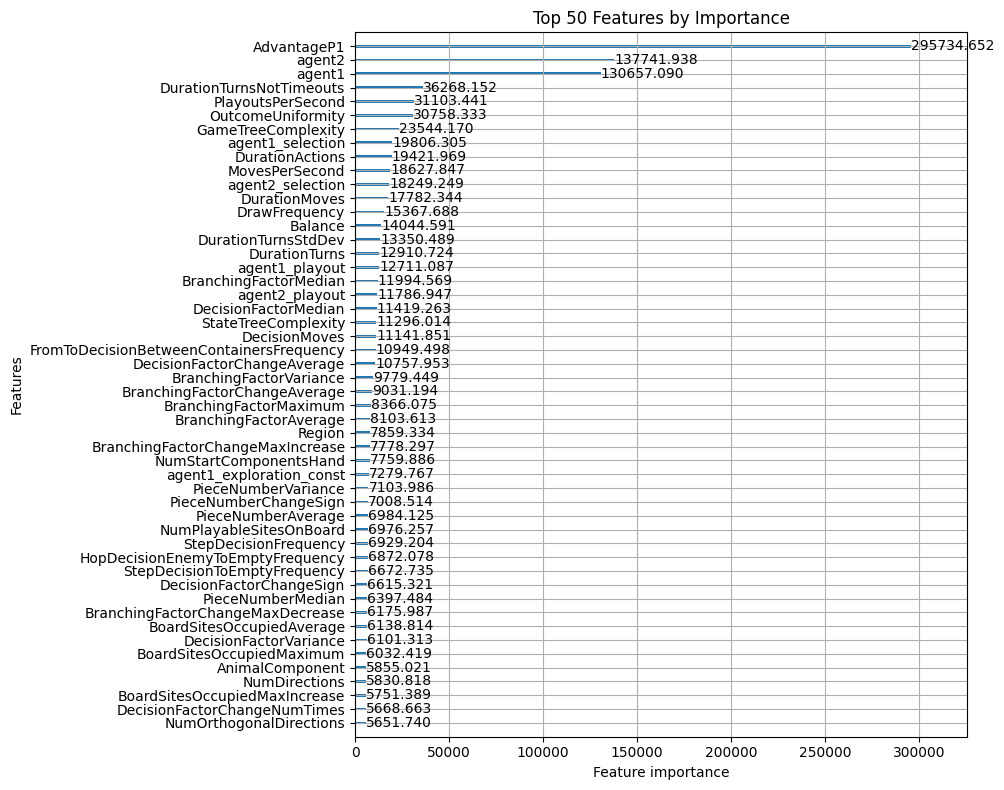

Fold 1 - RMSE: 0.4135483599420699
Fold 2


[100]	valid_0's rmse: 0.461219


[200]	valid_0's rmse: 0.441366


[300]	valid_0's rmse: 0.433211


[400]	valid_0's rmse: 0.427884


[500]	valid_0's rmse: 0.424625


[600]	valid_0's rmse: 0.422343


[700]	valid_0's rmse: 0.420311


[800]	valid_0's rmse: 0.418949


[900]	valid_0's rmse: 0.417631


[1000]	valid_0's rmse: 0.416255


[1100]	valid_0's rmse: 0.415073


[1200]	valid_0's rmse: 0.414211


[1300]	valid_0's rmse: 0.413274


[1400]	valid_0's rmse: 0.412647


[1500]	valid_0's rmse: 0.412101


[1600]	valid_0's rmse: 0.4115


[1700]	valid_0's rmse: 0.411032


[1800]	valid_0's rmse: 0.410573


[1900]	valid_0's rmse: 0.410344


[2000]	valid_0's rmse: 0.410058


[2100]	valid_0's rmse: 0.409702


[2200]	valid_0's rmse: 0.409376


[2300]	valid_0's rmse: 0.409152


[2400]	valid_0's rmse: 0.408759


[2500]	valid_0's rmse: 0.408328


[2600]	valid_0's rmse: 0.408146


[2700]	valid_0's rmse: 0.408035


[2800]	valid_0's rmse: 0.407957


[2900]	valid_0's rmse: 0.407828


[3000]	valid_0's rmse: 0.407601


[3100]	valid_0's rmse: 0.407333


[3200]	valid_0's rmse: 0.407202


[3300]	valid_0's rmse: 0.407187


[3400]	valid_0's rmse: 0.406964


[3500]	valid_0's rmse: 0.40681


[3600]	valid_0's rmse: 0.406738


[3700]	valid_0's rmse: 0.406677


[3800]	valid_0's rmse: 0.406565


[3900]	valid_0's rmse: 0.406475


[4000]	valid_0's rmse: 0.406341


[4100]	valid_0's rmse: 0.40614


[4200]	valid_0's rmse: 0.40603


[4300]	valid_0's rmse: 0.405936


[4400]	valid_0's rmse: 0.405914


[4500]	valid_0's rmse: 0.405849


[4600]	valid_0's rmse: 0.405822


[4700]	valid_0's rmse: 0.405867


[4800]	valid_0's rmse: 0.405856


[4900]	valid_0's rmse: 0.405798


[5000]	valid_0's rmse: 0.40572


[5100]	valid_0's rmse: 0.405671


[5200]	valid_0's rmse: 0.405729


[5300]	valid_0's rmse: 0.405746


[5400]	valid_0's rmse: 0.405768


[5500]	valid_0's rmse: 0.405863


[5600]	valid_0's rmse: 0.405793


[5700]	valid_0's rmse: 0.405727


[5800]	valid_0's rmse: 0.405721


[5900]	valid_0's rmse: 0.405625


[6000]	valid_0's rmse: 0.405625


[6100]	valid_0's rmse: 0.405628


[6200]	valid_0's rmse: 0.405569


[6300]	valid_0's rmse: 0.405485


[6400]	valid_0's rmse: 0.40547


[6500]	valid_0's rmse: 0.405489


[6600]	valid_0's rmse: 0.405454


[6700]	valid_0's rmse: 0.405473


[6800]	valid_0's rmse: 0.405443


[6900]	valid_0's rmse: 0.405379


[7000]	valid_0's rmse: 0.405361


[7100]	valid_0's rmse: 0.4053


[7200]	valid_0's rmse: 0.405264


[7300]	valid_0's rmse: 0.405289


[7400]	valid_0's rmse: 0.405305


[7500]	valid_0's rmse: 0.40535


[7600]	valid_0's rmse: 0.405308


[7700]	valid_0's rmse: 0.405337


[7800]	valid_0's rmse: 0.405417


[7900]	valid_0's rmse: 0.405398


[8000]	valid_0's rmse: 0.405431


[8100]	valid_0's rmse: 0.405454


[8200]	valid_0's rmse: 0.405464


[8300]	valid_0's rmse: 0.40545


[8400]	valid_0's rmse: 0.405413


[8500]	valid_0's rmse: 0.405397


[8600]	valid_0's rmse: 0.405423


[8700]	valid_0's rmse: 0.405431


[8800]	valid_0's rmse: 0.405455


[8900]	valid_0's rmse: 0.405477


[9000]	valid_0's rmse: 0.405502


[9100]	valid_0's rmse: 0.405525


[9200]	valid_0's rmse: 0.405469


[9300]	valid_0's rmse: 0.40546


[9400]	valid_0's rmse: 0.405496


[9500]	valid_0's rmse: 0.405513


[9600]	valid_0's rmse: 0.405477


[9700]	valid_0's rmse: 0.405499


[9800]	valid_0's rmse: 0.405493


[9900]	valid_0's rmse: 0.405496


[10000]	valid_0's rmse: 0.405508


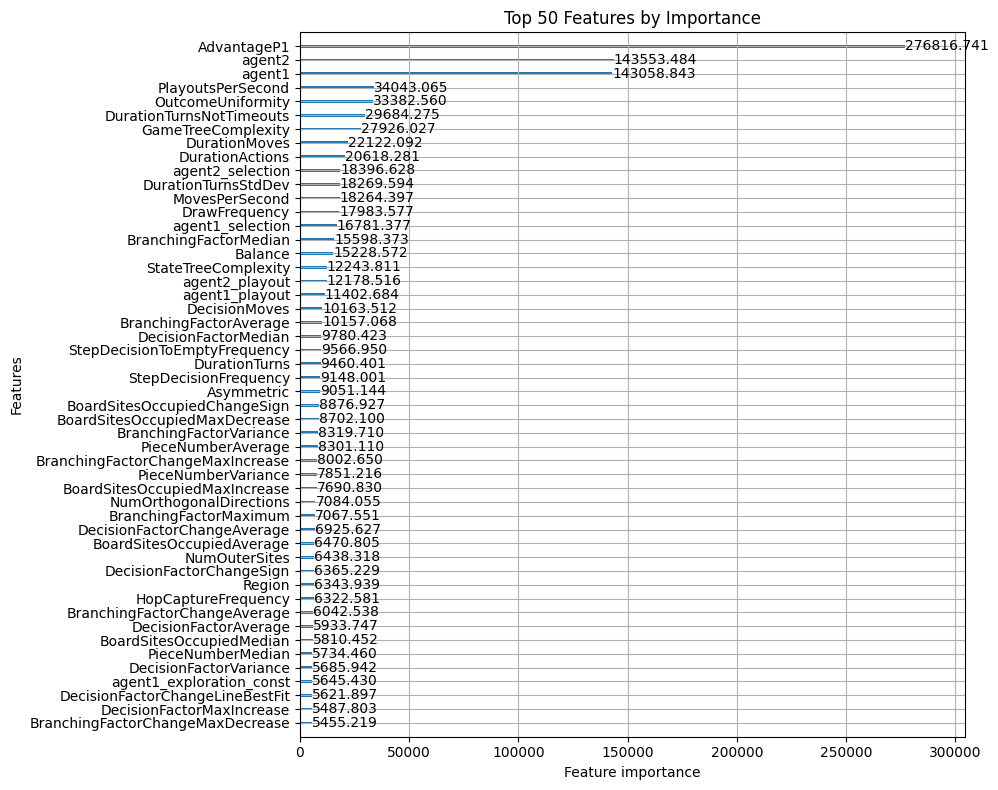

Fold 2 - RMSE: 0.4048688421945049
Fold 3


[100]	valid_0's rmse: 0.531853


[200]	valid_0's rmse: 0.504352


[300]	valid_0's rmse: 0.489496


[400]	valid_0's rmse: 0.482079


[500]	valid_0's rmse: 0.476101


[600]	valid_0's rmse: 0.472139


[700]	valid_0's rmse: 0.468242


[800]	valid_0's rmse: 0.465052


[900]	valid_0's rmse: 0.462923


[1000]	valid_0's rmse: 0.46057


[1100]	valid_0's rmse: 0.458736


[1200]	valid_0's rmse: 0.45725


[1300]	valid_0's rmse: 0.456126


[1400]	valid_0's rmse: 0.454901


[1500]	valid_0's rmse: 0.454113


[1600]	valid_0's rmse: 0.453151


[1700]	valid_0's rmse: 0.452162


[1800]	valid_0's rmse: 0.451534


[1900]	valid_0's rmse: 0.450773


[2000]	valid_0's rmse: 0.450113


[2100]	valid_0's rmse: 0.449739


[2200]	valid_0's rmse: 0.44923


[2300]	valid_0's rmse: 0.448729


[2400]	valid_0's rmse: 0.448223


[2500]	valid_0's rmse: 0.447888


[2600]	valid_0's rmse: 0.447363


[2700]	valid_0's rmse: 0.447076


[2800]	valid_0's rmse: 0.446736


[2900]	valid_0's rmse: 0.446405


[3000]	valid_0's rmse: 0.446046


[3100]	valid_0's rmse: 0.445764


[3200]	valid_0's rmse: 0.44551


[3300]	valid_0's rmse: 0.445183


[3400]	valid_0's rmse: 0.444902


[3500]	valid_0's rmse: 0.444698


[3600]	valid_0's rmse: 0.444442


[3700]	valid_0's rmse: 0.444306


[3800]	valid_0's rmse: 0.444005


[3900]	valid_0's rmse: 0.443764


[4000]	valid_0's rmse: 0.443576


[4100]	valid_0's rmse: 0.443383


[4200]	valid_0's rmse: 0.443232


[4300]	valid_0's rmse: 0.443148


[4400]	valid_0's rmse: 0.442996


[4500]	valid_0's rmse: 0.442877


[4600]	valid_0's rmse: 0.44269


[4700]	valid_0's rmse: 0.442555


[4800]	valid_0's rmse: 0.44242


[4900]	valid_0's rmse: 0.442229


[5000]	valid_0's rmse: 0.442137


[5100]	valid_0's rmse: 0.442005


[5200]	valid_0's rmse: 0.441828


[5300]	valid_0's rmse: 0.441815


[5400]	valid_0's rmse: 0.441646


[5500]	valid_0's rmse: 0.4415


[5600]	valid_0's rmse: 0.441404


[5700]	valid_0's rmse: 0.441288


[5800]	valid_0's rmse: 0.44117


[5900]	valid_0's rmse: 0.441057


[6000]	valid_0's rmse: 0.440883


[6100]	valid_0's rmse: 0.440905


[6200]	valid_0's rmse: 0.440853


[6300]	valid_0's rmse: 0.440778


[6400]	valid_0's rmse: 0.44069


[6500]	valid_0's rmse: 0.440592


[6600]	valid_0's rmse: 0.440622


[6700]	valid_0's rmse: 0.440552


[6800]	valid_0's rmse: 0.440466


[6900]	valid_0's rmse: 0.440361


[7000]	valid_0's rmse: 0.440264


[7100]	valid_0's rmse: 0.440165


[7200]	valid_0's rmse: 0.440078


[7300]	valid_0's rmse: 0.440021


[7400]	valid_0's rmse: 0.440026


[7500]	valid_0's rmse: 0.439987


[7600]	valid_0's rmse: 0.439935


[7700]	valid_0's rmse: 0.439874


[7800]	valid_0's rmse: 0.43982


[7900]	valid_0's rmse: 0.439823


[8000]	valid_0's rmse: 0.439778


[8100]	valid_0's rmse: 0.439667


[8200]	valid_0's rmse: 0.439638


[8300]	valid_0's rmse: 0.439618


[8400]	valid_0's rmse: 0.439561


[8500]	valid_0's rmse: 0.4395


[8600]	valid_0's rmse: 0.43946


[8700]	valid_0's rmse: 0.439435


[8800]	valid_0's rmse: 0.439416


[8900]	valid_0's rmse: 0.439403


[9000]	valid_0's rmse: 0.439384


[9100]	valid_0's rmse: 0.439371


[9200]	valid_0's rmse: 0.439397


[9300]	valid_0's rmse: 0.439339


[9400]	valid_0's rmse: 0.439325


[9500]	valid_0's rmse: 0.439295


[9600]	valid_0's rmse: 0.439311


[9700]	valid_0's rmse: 0.439222


[9800]	valid_0's rmse: 0.439175


[9900]	valid_0's rmse: 0.439176


[10000]	valid_0's rmse: 0.439136


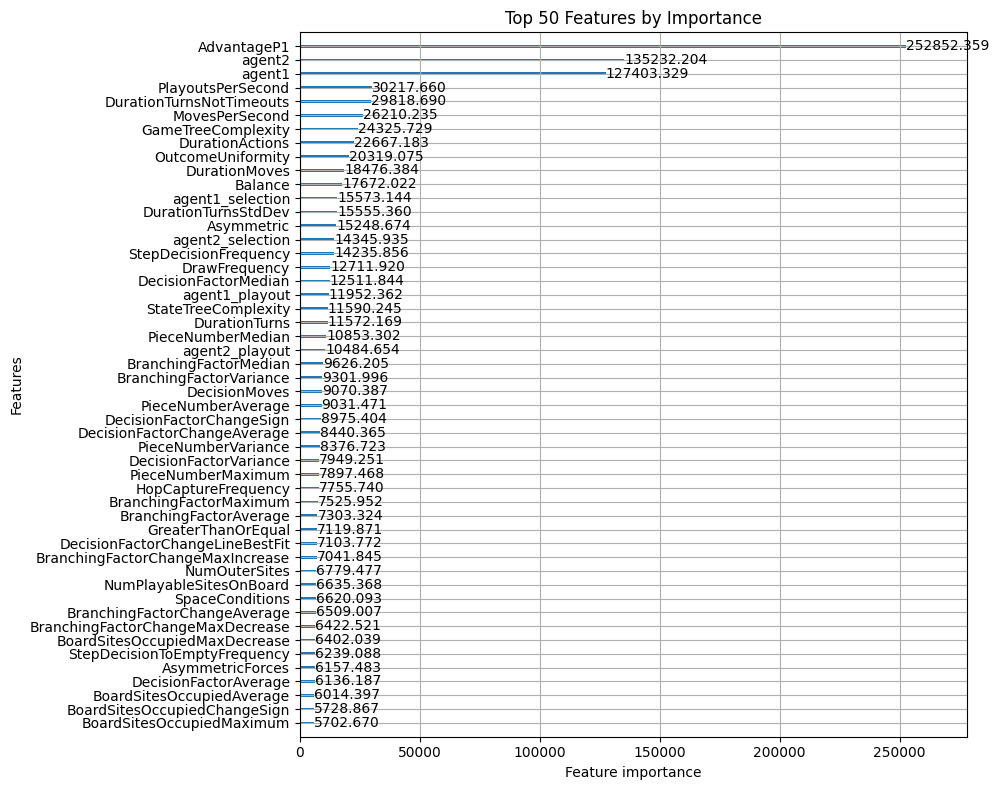

Fold 3 - RMSE: 0.4383674733507195
Fold 4


[100]	valid_0's rmse: 0.524269


[200]	valid_0's rmse: 0.498441


[300]	valid_0's rmse: 0.486585


[400]	valid_0's rmse: 0.478005


[500]	valid_0's rmse: 0.472622


[600]	valid_0's rmse: 0.469246


[700]	valid_0's rmse: 0.466419


[800]	valid_0's rmse: 0.464203


[900]	valid_0's rmse: 0.462629


[1000]	valid_0's rmse: 0.460731


[1100]	valid_0's rmse: 0.45951


[1200]	valid_0's rmse: 0.458375


[1300]	valid_0's rmse: 0.457228


[1400]	valid_0's rmse: 0.456178


[1500]	valid_0's rmse: 0.455299


[1600]	valid_0's rmse: 0.45451


[1700]	valid_0's rmse: 0.453691


[1800]	valid_0's rmse: 0.453097


[1900]	valid_0's rmse: 0.452418


[2000]	valid_0's rmse: 0.451956


[2100]	valid_0's rmse: 0.451518


[2200]	valid_0's rmse: 0.451083


[2300]	valid_0's rmse: 0.450604


[2400]	valid_0's rmse: 0.450227


[2500]	valid_0's rmse: 0.449895


[2600]	valid_0's rmse: 0.449459


[2700]	valid_0's rmse: 0.449222


[2800]	valid_0's rmse: 0.448889


[2900]	valid_0's rmse: 0.448598


[3000]	valid_0's rmse: 0.448338


[3100]	valid_0's rmse: 0.448087


[3200]	valid_0's rmse: 0.447795


[3300]	valid_0's rmse: 0.447512


[3400]	valid_0's rmse: 0.44726


[3500]	valid_0's rmse: 0.447048


[3600]	valid_0's rmse: 0.446879


[3700]	valid_0's rmse: 0.446665


[3800]	valid_0's rmse: 0.446527


[3900]	valid_0's rmse: 0.446346


[4000]	valid_0's rmse: 0.446197


[4100]	valid_0's rmse: 0.445992


[4200]	valid_0's rmse: 0.445798


[4300]	valid_0's rmse: 0.445642


[4400]	valid_0's rmse: 0.445474


[4500]	valid_0's rmse: 0.445282


[4600]	valid_0's rmse: 0.445254


[4700]	valid_0's rmse: 0.445137


[4800]	valid_0's rmse: 0.445028


[4900]	valid_0's rmse: 0.444916


[5000]	valid_0's rmse: 0.444828


[5100]	valid_0's rmse: 0.444777


[5200]	valid_0's rmse: 0.444666


[5300]	valid_0's rmse: 0.444504


[5400]	valid_0's rmse: 0.444487


[5500]	valid_0's rmse: 0.444394


[5600]	valid_0's rmse: 0.444288


[5700]	valid_0's rmse: 0.444201


[5800]	valid_0's rmse: 0.44416


[5900]	valid_0's rmse: 0.444129


[6000]	valid_0's rmse: 0.443955


[6100]	valid_0's rmse: 0.443935


[6200]	valid_0's rmse: 0.443842


[6300]	valid_0's rmse: 0.443799


[6400]	valid_0's rmse: 0.443715


[6500]	valid_0's rmse: 0.443702


[6600]	valid_0's rmse: 0.443636


[6700]	valid_0's rmse: 0.443546


[6800]	valid_0's rmse: 0.443447


[6900]	valid_0's rmse: 0.443432


[7000]	valid_0's rmse: 0.443343


[7100]	valid_0's rmse: 0.443266


[7200]	valid_0's rmse: 0.44326


[7300]	valid_0's rmse: 0.443243


[7400]	valid_0's rmse: 0.443246


[7500]	valid_0's rmse: 0.443149


[7600]	valid_0's rmse: 0.443056


[7700]	valid_0's rmse: 0.443006


[7800]	valid_0's rmse: 0.442963


[7900]	valid_0's rmse: 0.442911


[8000]	valid_0's rmse: 0.442895


[8100]	valid_0's rmse: 0.442869


[8200]	valid_0's rmse: 0.442898


[8300]	valid_0's rmse: 0.442769


[8400]	valid_0's rmse: 0.442738


[8500]	valid_0's rmse: 0.442693


[8600]	valid_0's rmse: 0.442713


[8700]	valid_0's rmse: 0.442686


[8800]	valid_0's rmse: 0.44272


[8900]	valid_0's rmse: 0.442643


[9000]	valid_0's rmse: 0.442638


[9100]	valid_0's rmse: 0.442623


[9200]	valid_0's rmse: 0.442543


[9300]	valid_0's rmse: 0.442511


[9400]	valid_0's rmse: 0.442491


[9500]	valid_0's rmse: 0.442468


[9600]	valid_0's rmse: 0.442473


[9700]	valid_0's rmse: 0.442479


[9800]	valid_0's rmse: 0.442446


[9900]	valid_0's rmse: 0.442441


[10000]	valid_0's rmse: 0.442464


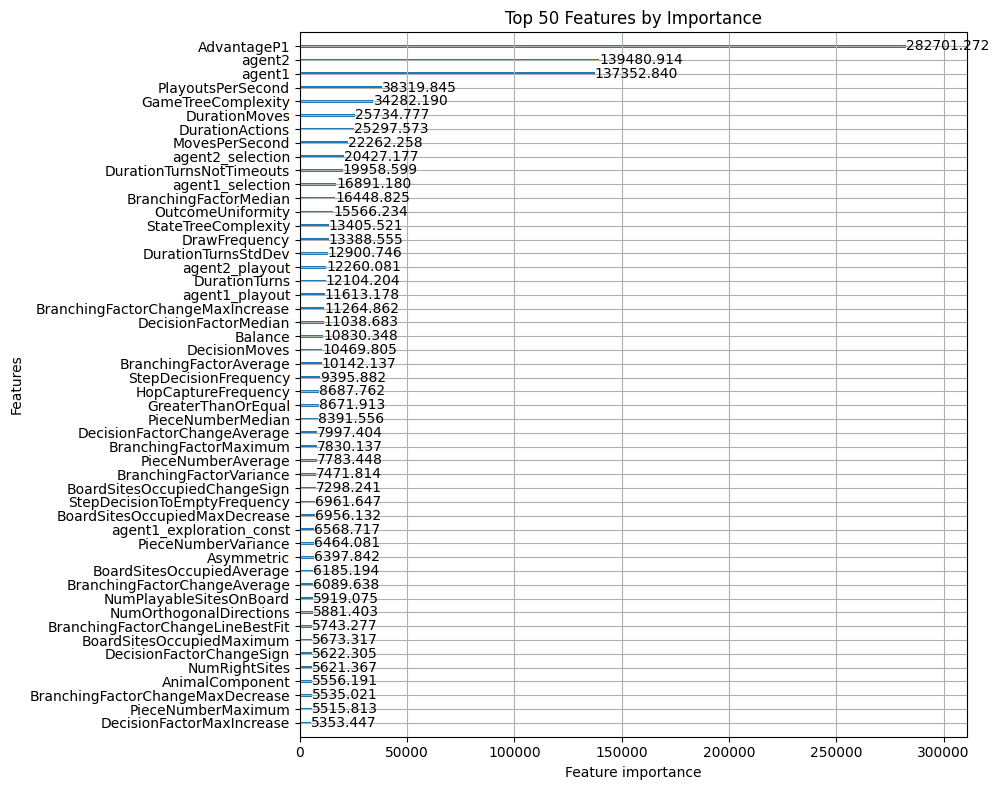

Fold 4 - RMSE: 0.44207500213903433
Fold 5


[100]	valid_0's rmse: 0.519203


[200]	valid_0's rmse: 0.495047


[300]	valid_0's rmse: 0.482201


[400]	valid_0's rmse: 0.47414


[500]	valid_0's rmse: 0.468607


[600]	valid_0's rmse: 0.464186


[700]	valid_0's rmse: 0.461075


[800]	valid_0's rmse: 0.45783


[900]	valid_0's rmse: 0.455253


[1000]	valid_0's rmse: 0.453116


[1100]	valid_0's rmse: 0.451089


[1200]	valid_0's rmse: 0.449595


[1300]	valid_0's rmse: 0.448262


[1400]	valid_0's rmse: 0.446997


[1500]	valid_0's rmse: 0.446034


[1600]	valid_0's rmse: 0.445032


[1700]	valid_0's rmse: 0.443958


[1800]	valid_0's rmse: 0.443231


[1900]	valid_0's rmse: 0.442495


[2000]	valid_0's rmse: 0.441697


[2100]	valid_0's rmse: 0.441147


[2200]	valid_0's rmse: 0.440513


[2300]	valid_0's rmse: 0.439917


[2400]	valid_0's rmse: 0.439405


[2500]	valid_0's rmse: 0.438977


[2600]	valid_0's rmse: 0.438615


[2700]	valid_0's rmse: 0.438408


[2800]	valid_0's rmse: 0.438124


[2900]	valid_0's rmse: 0.43786


[3000]	valid_0's rmse: 0.437481


[3100]	valid_0's rmse: 0.437224


[3200]	valid_0's rmse: 0.43695


[3300]	valid_0's rmse: 0.436621


[3400]	valid_0's rmse: 0.436404


[3500]	valid_0's rmse: 0.436179


[3600]	valid_0's rmse: 0.435943


[3700]	valid_0's rmse: 0.435767


[3800]	valid_0's rmse: 0.435705


[3900]	valid_0's rmse: 0.435475


[4000]	valid_0's rmse: 0.435357


[4100]	valid_0's rmse: 0.435242


[4200]	valid_0's rmse: 0.435033


[4300]	valid_0's rmse: 0.434894


[4400]	valid_0's rmse: 0.434788


[4500]	valid_0's rmse: 0.434677


[4600]	valid_0's rmse: 0.434496


[4700]	valid_0's rmse: 0.434451


[4800]	valid_0's rmse: 0.434357


[4900]	valid_0's rmse: 0.434293


[5000]	valid_0's rmse: 0.434182


[5100]	valid_0's rmse: 0.434067


[5200]	valid_0's rmse: 0.433968


[5300]	valid_0's rmse: 0.433916


[5400]	valid_0's rmse: 0.433791


[5500]	valid_0's rmse: 0.433714


[5600]	valid_0's rmse: 0.433665


[5700]	valid_0's rmse: 0.433625


[5800]	valid_0's rmse: 0.433573


[5900]	valid_0's rmse: 0.433535


[6000]	valid_0's rmse: 0.433407


[6100]	valid_0's rmse: 0.433318


[6200]	valid_0's rmse: 0.433227


[6300]	valid_0's rmse: 0.433265


[6400]	valid_0's rmse: 0.433204


[6500]	valid_0's rmse: 0.433174


[6600]	valid_0's rmse: 0.433088


[6700]	valid_0's rmse: 0.432958


[6800]	valid_0's rmse: 0.43293


[6900]	valid_0's rmse: 0.432851


[7000]	valid_0's rmse: 0.432828


[7100]	valid_0's rmse: 0.432784


[7200]	valid_0's rmse: 0.432758


[7300]	valid_0's rmse: 0.432746


[7400]	valid_0's rmse: 0.432689


[7500]	valid_0's rmse: 0.432665


[7600]	valid_0's rmse: 0.432591


[7700]	valid_0's rmse: 0.432553


[7800]	valid_0's rmse: 0.432544


[7900]	valid_0's rmse: 0.432529


[8000]	valid_0's rmse: 0.432433


[8100]	valid_0's rmse: 0.432399


[8200]	valid_0's rmse: 0.432402


[8300]	valid_0's rmse: 0.432376


[8400]	valid_0's rmse: 0.432357


[8500]	valid_0's rmse: 0.432295


[8600]	valid_0's rmse: 0.432286


[8700]	valid_0's rmse: 0.432252


[8800]	valid_0's rmse: 0.432274


[8900]	valid_0's rmse: 0.432288


[9000]	valid_0's rmse: 0.4323


[9100]	valid_0's rmse: 0.432231


[9200]	valid_0's rmse: 0.4322


[9300]	valid_0's rmse: 0.432145


[9400]	valid_0's rmse: 0.432111


[9500]	valid_0's rmse: 0.432041


[9600]	valid_0's rmse: 0.432035


[9700]	valid_0's rmse: 0.431956


[9800]	valid_0's rmse: 0.431925


[9900]	valid_0's rmse: 0.431921


[10000]	valid_0's rmse: 0.431893


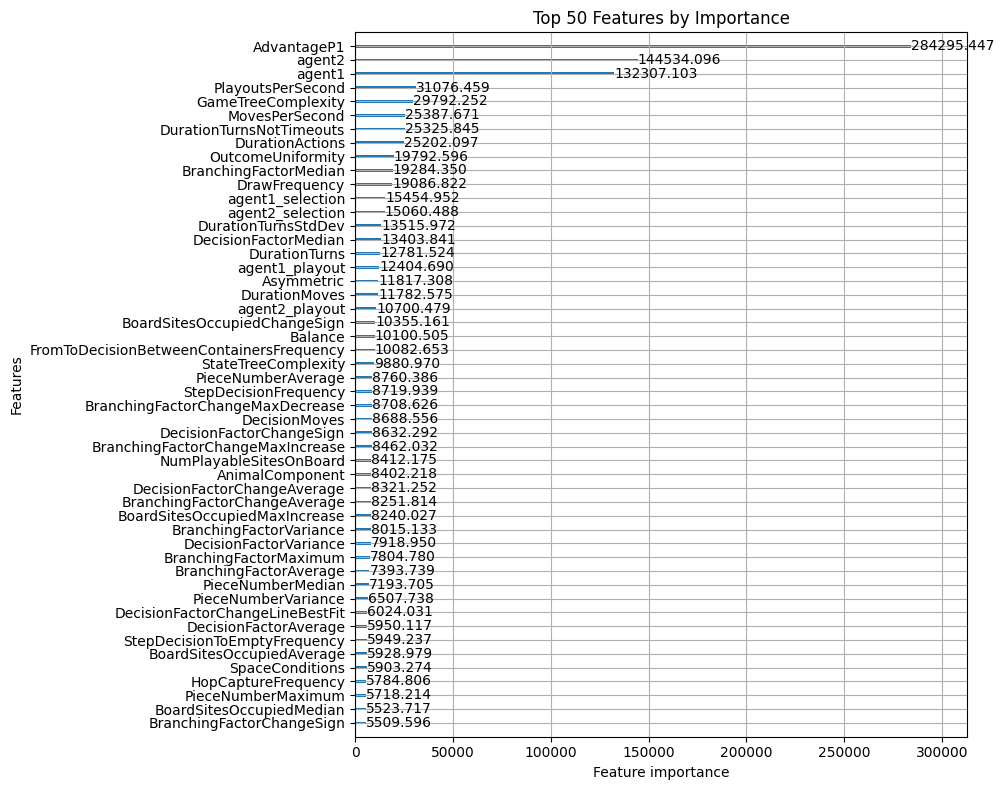

Fold 5 - RMSE: 0.4312514165720395
List of oof scores: [0.4135483599420699, 0.4048688421945049, 0.4383674733507195, 0.44207500213903433, 0.4312514165720395]
Average oof score: 0.4260222188396736


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.507786


[200]	valid_0's rmse: 0.486044


[300]	valid_0's rmse: 0.474099


[400]	valid_0's rmse: 0.468207


[500]	valid_0's rmse: 0.463589


[600]	valid_0's rmse: 0.460009


[700]	valid_0's rmse: 0.456921


[800]	valid_0's rmse: 0.454694


[900]	valid_0's rmse: 0.452594


[1000]	valid_0's rmse: 0.45082


[1100]	valid_0's rmse: 0.449649


[1200]	valid_0's rmse: 0.448504


[1300]	valid_0's rmse: 0.447339


[1400]	valid_0's rmse: 0.446402


[1500]	valid_0's rmse: 0.445759


[1600]	valid_0's rmse: 0.444964


[1700]	valid_0's rmse: 0.444201


[1800]	valid_0's rmse: 0.443485


[1900]	valid_0's rmse: 0.44271


[2000]	valid_0's rmse: 0.442173


[2100]	valid_0's rmse: 0.441784


[2200]	valid_0's rmse: 0.441572


[2300]	valid_0's rmse: 0.441243


[2400]	valid_0's rmse: 0.44093


[2500]	valid_0's rmse: 0.44048


[2600]	valid_0's rmse: 0.440135


[2700]	valid_0's rmse: 0.43989


[2800]	valid_0's rmse: 0.439596


[2900]	valid_0's rmse: 0.439447


[3000]	valid_0's rmse: 0.43917


[3100]	valid_0's rmse: 0.438959


[3200]	valid_0's rmse: 0.438722


[3300]	valid_0's rmse: 0.438487


[3400]	valid_0's rmse: 0.438397


[3500]	valid_0's rmse: 0.438297


[3600]	valid_0's rmse: 0.438189


[3700]	valid_0's rmse: 0.438144


[3800]	valid_0's rmse: 0.438029


[3900]	valid_0's rmse: 0.437854


[4000]	valid_0's rmse: 0.437727


[4100]	valid_0's rmse: 0.437617


[4200]	valid_0's rmse: 0.437505


[4300]	valid_0's rmse: 0.437478


[4400]	valid_0's rmse: 0.437352


[4500]	valid_0's rmse: 0.437212


[4600]	valid_0's rmse: 0.437079


[4700]	valid_0's rmse: 0.436951


[4800]	valid_0's rmse: 0.436926


[4900]	valid_0's rmse: 0.4368


[5000]	valid_0's rmse: 0.436754


[5100]	valid_0's rmse: 0.436655


[5200]	valid_0's rmse: 0.436614


[5300]	valid_0's rmse: 0.436574


[5400]	valid_0's rmse: 0.436526


[5500]	valid_0's rmse: 0.436501


[5600]	valid_0's rmse: 0.436398


[5700]	valid_0's rmse: 0.436354


[5800]	valid_0's rmse: 0.436282


[5900]	valid_0's rmse: 0.4362


[6000]	valid_0's rmse: 0.436124


[6100]	valid_0's rmse: 0.436078


[6200]	valid_0's rmse: 0.436036


[6300]	valid_0's rmse: 0.435975


[6400]	valid_0's rmse: 0.435945


[6500]	valid_0's rmse: 0.435939


[6600]	valid_0's rmse: 0.43591


[6700]	valid_0's rmse: 0.435854


[6800]	valid_0's rmse: 0.435756


[6900]	valid_0's rmse: 0.435836


[7000]	valid_0's rmse: 0.435791


[7100]	valid_0's rmse: 0.435706


[7200]	valid_0's rmse: 0.43563


[7300]	valid_0's rmse: 0.43564


[7400]	valid_0's rmse: 0.435632


[7500]	valid_0's rmse: 0.435661


[7600]	valid_0's rmse: 0.435641


[7700]	valid_0's rmse: 0.435706


[7800]	valid_0's rmse: 0.435643


[7900]	valid_0's rmse: 0.435685


[8000]	valid_0's rmse: 0.435685


[8100]	valid_0's rmse: 0.435644


[8200]	valid_0's rmse: 0.435638


[8300]	valid_0's rmse: 0.435609


[8400]	valid_0's rmse: 0.43557


[8500]	valid_0's rmse: 0.435515


[8600]	valid_0's rmse: 0.43552


[8700]	valid_0's rmse: 0.435487


[8800]	valid_0's rmse: 0.435405


[8900]	valid_0's rmse: 0.435381


[9000]	valid_0's rmse: 0.435369


[9100]	valid_0's rmse: 0.435354


[9200]	valid_0's rmse: 0.435263


[9300]	valid_0's rmse: 0.43528


[9400]	valid_0's rmse: 0.435227


[9500]	valid_0's rmse: 0.435203


[9600]	valid_0's rmse: 0.435166


[9700]	valid_0's rmse: 0.435191


[9800]	valid_0's rmse: 0.435186


[9900]	valid_0's rmse: 0.435164


[10000]	valid_0's rmse: 0.435177


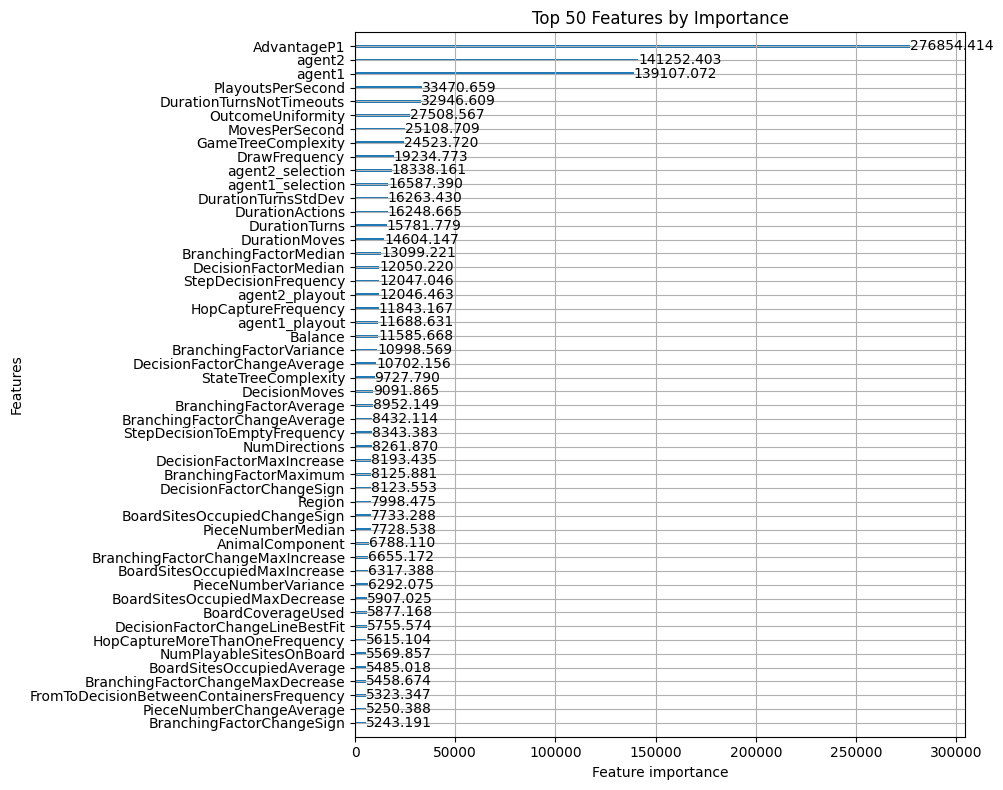

Fold 1 - RMSE: 0.43460173532810337
Fold 2


[100]	valid_0's rmse: 0.506187


[200]	valid_0's rmse: 0.482696


[300]	valid_0's rmse: 0.469408


[400]	valid_0's rmse: 0.461069


[500]	valid_0's rmse: 0.455257


[600]	valid_0's rmse: 0.449733


[700]	valid_0's rmse: 0.446127


[800]	valid_0's rmse: 0.443454


[900]	valid_0's rmse: 0.440876


[1000]	valid_0's rmse: 0.438498


[1100]	valid_0's rmse: 0.436473


[1200]	valid_0's rmse: 0.434786


[1300]	valid_0's rmse: 0.433415


[1400]	valid_0's rmse: 0.432114


[1500]	valid_0's rmse: 0.430619


[1600]	valid_0's rmse: 0.429492


[1700]	valid_0's rmse: 0.428502


[1800]	valid_0's rmse: 0.427373


[1900]	valid_0's rmse: 0.426643


[2000]	valid_0's rmse: 0.426081


[2100]	valid_0's rmse: 0.425316


[2200]	valid_0's rmse: 0.424647


[2300]	valid_0's rmse: 0.424126


[2400]	valid_0's rmse: 0.423524


[2500]	valid_0's rmse: 0.42299


[2600]	valid_0's rmse: 0.422616


[2700]	valid_0's rmse: 0.422171


[2800]	valid_0's rmse: 0.421738


[2900]	valid_0's rmse: 0.421308


[3000]	valid_0's rmse: 0.420881


[3100]	valid_0's rmse: 0.420494


[3200]	valid_0's rmse: 0.420051


[3300]	valid_0's rmse: 0.419715


[3400]	valid_0's rmse: 0.419457


[3500]	valid_0's rmse: 0.419111


[3600]	valid_0's rmse: 0.418855


[3700]	valid_0's rmse: 0.418583


[3800]	valid_0's rmse: 0.418425


[3900]	valid_0's rmse: 0.418267


[4000]	valid_0's rmse: 0.418091


[4100]	valid_0's rmse: 0.417834


[4200]	valid_0's rmse: 0.417616


[4300]	valid_0's rmse: 0.417365


[4400]	valid_0's rmse: 0.417098


[4500]	valid_0's rmse: 0.416951


[4600]	valid_0's rmse: 0.416839


[4700]	valid_0's rmse: 0.416677


[4800]	valid_0's rmse: 0.416509


[4900]	valid_0's rmse: 0.416344


[5000]	valid_0's rmse: 0.416241


[5100]	valid_0's rmse: 0.416115


[5200]	valid_0's rmse: 0.416041


[5300]	valid_0's rmse: 0.415818


[5400]	valid_0's rmse: 0.415675


[5500]	valid_0's rmse: 0.415525


[5600]	valid_0's rmse: 0.41543


[5700]	valid_0's rmse: 0.41532


[5800]	valid_0's rmse: 0.415202


[5900]	valid_0's rmse: 0.415133


[6000]	valid_0's rmse: 0.415149


[6100]	valid_0's rmse: 0.415057


[6200]	valid_0's rmse: 0.414928


[6300]	valid_0's rmse: 0.414814


[6400]	valid_0's rmse: 0.414719


[6500]	valid_0's rmse: 0.414589


[6600]	valid_0's rmse: 0.414555


[6700]	valid_0's rmse: 0.414449


[6800]	valid_0's rmse: 0.414432


[6900]	valid_0's rmse: 0.414401


[7000]	valid_0's rmse: 0.414381


[7100]	valid_0's rmse: 0.414362


[7200]	valid_0's rmse: 0.414347


[7300]	valid_0's rmse: 0.414264


[7400]	valid_0's rmse: 0.414237


[7500]	valid_0's rmse: 0.414203


[7600]	valid_0's rmse: 0.414158


[7700]	valid_0's rmse: 0.414101


[7800]	valid_0's rmse: 0.414075


[7900]	valid_0's rmse: 0.413962


[8000]	valid_0's rmse: 0.413905


[8100]	valid_0's rmse: 0.413908


[8200]	valid_0's rmse: 0.413853


[8300]	valid_0's rmse: 0.413807


[8400]	valid_0's rmse: 0.413786


[8500]	valid_0's rmse: 0.413743


[8600]	valid_0's rmse: 0.413688


[8700]	valid_0's rmse: 0.413641


[8800]	valid_0's rmse: 0.413645


[8900]	valid_0's rmse: 0.413594


[9000]	valid_0's rmse: 0.413576


[9100]	valid_0's rmse: 0.41353


[9200]	valid_0's rmse: 0.413461


[9300]	valid_0's rmse: 0.413485


[9400]	valid_0's rmse: 0.413466


[9500]	valid_0's rmse: 0.413457


[9600]	valid_0's rmse: 0.413409


[9700]	valid_0's rmse: 0.413347


[9800]	valid_0's rmse: 0.413331


[9900]	valid_0's rmse: 0.413343


[10000]	valid_0's rmse: 0.413285


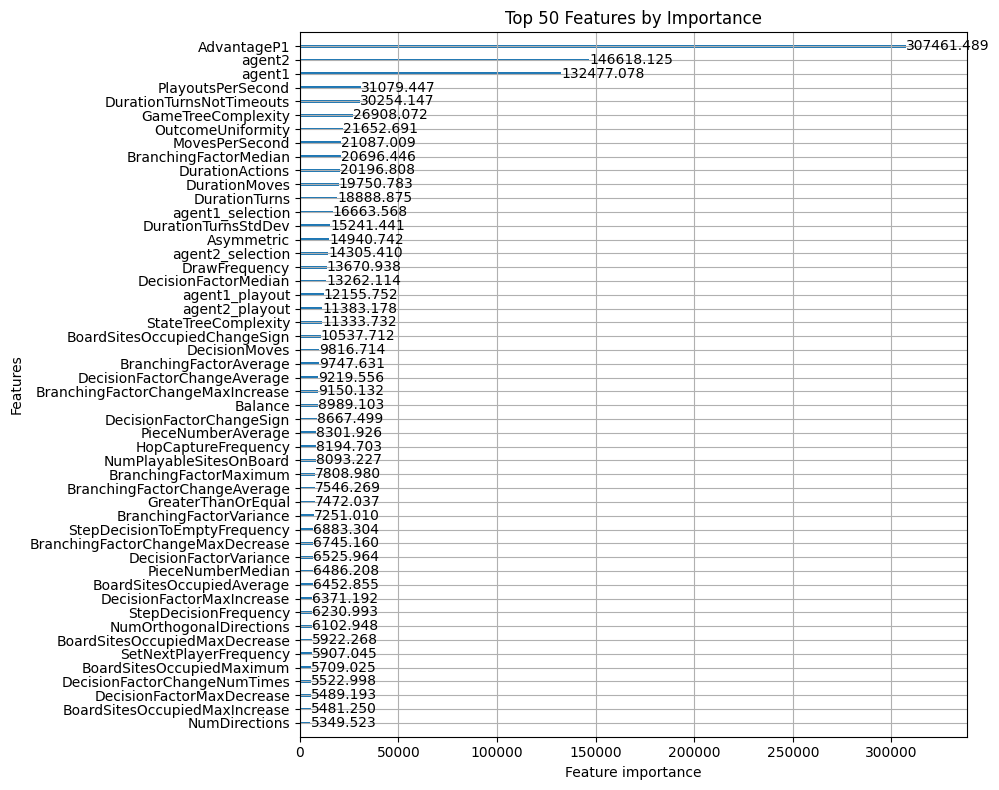

Fold 2 - RMSE: 0.41286886521910343
Fold 3


[100]	valid_0's rmse: 0.498442


[200]	valid_0's rmse: 0.474008


[300]	valid_0's rmse: 0.462687


[400]	valid_0's rmse: 0.455485


[500]	valid_0's rmse: 0.450731


[600]	valid_0's rmse: 0.447579


[700]	valid_0's rmse: 0.445512


[800]	valid_0's rmse: 0.443441


[900]	valid_0's rmse: 0.441754


[1000]	valid_0's rmse: 0.44021


[1100]	valid_0's rmse: 0.4389


[1200]	valid_0's rmse: 0.437763


[1300]	valid_0's rmse: 0.436938


[1400]	valid_0's rmse: 0.436215


[1500]	valid_0's rmse: 0.435466


[1600]	valid_0's rmse: 0.434822


[1700]	valid_0's rmse: 0.434268


[1800]	valid_0's rmse: 0.43366


[1900]	valid_0's rmse: 0.433245


[2000]	valid_0's rmse: 0.432855


[2100]	valid_0's rmse: 0.432478


[2200]	valid_0's rmse: 0.432094


[2300]	valid_0's rmse: 0.431899


[2400]	valid_0's rmse: 0.431568


[2500]	valid_0's rmse: 0.431307


[2600]	valid_0's rmse: 0.431053


[2700]	valid_0's rmse: 0.43093


[2800]	valid_0's rmse: 0.430807


[2900]	valid_0's rmse: 0.430637


[3000]	valid_0's rmse: 0.430541


[3100]	valid_0's rmse: 0.430379


[3200]	valid_0's rmse: 0.430232


[3300]	valid_0's rmse: 0.430091


[3400]	valid_0's rmse: 0.429947


[3500]	valid_0's rmse: 0.429745


[3600]	valid_0's rmse: 0.429511


[3700]	valid_0's rmse: 0.429446


[3800]	valid_0's rmse: 0.429256


[3900]	valid_0's rmse: 0.429046


[4000]	valid_0's rmse: 0.428939


[4100]	valid_0's rmse: 0.428863


[4200]	valid_0's rmse: 0.428631


[4300]	valid_0's rmse: 0.428582


[4400]	valid_0's rmse: 0.428516


[4500]	valid_0's rmse: 0.428426


[4600]	valid_0's rmse: 0.428347


[4700]	valid_0's rmse: 0.428262


[4800]	valid_0's rmse: 0.428121


[4900]	valid_0's rmse: 0.428023


[5000]	valid_0's rmse: 0.427994


[5100]	valid_0's rmse: 0.427904


[5200]	valid_0's rmse: 0.427873


[5300]	valid_0's rmse: 0.427766


[5400]	valid_0's rmse: 0.42771


[5500]	valid_0's rmse: 0.427632


[5600]	valid_0's rmse: 0.427563


[5700]	valid_0's rmse: 0.427546


[5800]	valid_0's rmse: 0.427541


[5900]	valid_0's rmse: 0.427477


[6000]	valid_0's rmse: 0.427439


[6100]	valid_0's rmse: 0.427408


[6200]	valid_0's rmse: 0.427312


[6300]	valid_0's rmse: 0.427225


[6400]	valid_0's rmse: 0.427193


[6500]	valid_0's rmse: 0.427214


[6600]	valid_0's rmse: 0.427206


[6700]	valid_0's rmse: 0.427143


[6800]	valid_0's rmse: 0.427137


[6900]	valid_0's rmse: 0.427074


[7000]	valid_0's rmse: 0.427055


[7100]	valid_0's rmse: 0.426992


[7200]	valid_0's rmse: 0.427038


[7300]	valid_0's rmse: 0.427006


[7400]	valid_0's rmse: 0.426969


[7500]	valid_0's rmse: 0.426873


[7600]	valid_0's rmse: 0.426921


[7700]	valid_0's rmse: 0.426931


[7800]	valid_0's rmse: 0.426849


[7900]	valid_0's rmse: 0.426816


[8000]	valid_0's rmse: 0.426813


[8100]	valid_0's rmse: 0.42673


[8200]	valid_0's rmse: 0.426707


[8300]	valid_0's rmse: 0.426747


[8400]	valid_0's rmse: 0.426726


[8500]	valid_0's rmse: 0.426752


[8600]	valid_0's rmse: 0.426743


[8700]	valid_0's rmse: 0.426756


[8800]	valid_0's rmse: 0.426779


[8900]	valid_0's rmse: 0.426793


[9000]	valid_0's rmse: 0.426725


[9100]	valid_0's rmse: 0.426705


[9200]	valid_0's rmse: 0.426706


[9300]	valid_0's rmse: 0.426688


[9400]	valid_0's rmse: 0.42669


[9500]	valid_0's rmse: 0.426695


[9600]	valid_0's rmse: 0.426645


[9700]	valid_0's rmse: 0.426584


[9800]	valid_0's rmse: 0.426559


[9900]	valid_0's rmse: 0.426596


[10000]	valid_0's rmse: 0.42659


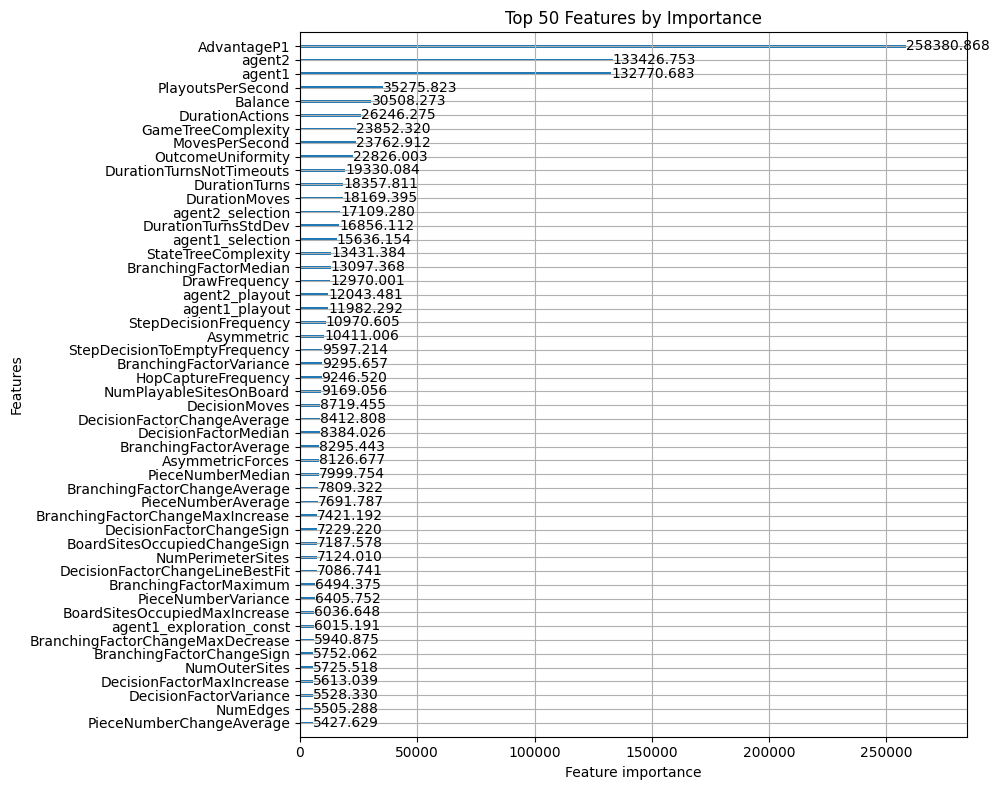

Fold 3 - RMSE: 0.4261046050115251
Fold 4


[100]	valid_0's rmse: 0.488535


[200]	valid_0's rmse: 0.465675


[300]	valid_0's rmse: 0.45504


[400]	valid_0's rmse: 0.448688


[500]	valid_0's rmse: 0.443643


[600]	valid_0's rmse: 0.440623


[700]	valid_0's rmse: 0.437532


[800]	valid_0's rmse: 0.434832


[900]	valid_0's rmse: 0.433227


[1000]	valid_0's rmse: 0.431742


[1100]	valid_0's rmse: 0.430328


[1200]	valid_0's rmse: 0.429075


[1300]	valid_0's rmse: 0.427947


[1400]	valid_0's rmse: 0.426969


[1500]	valid_0's rmse: 0.426217


[1600]	valid_0's rmse: 0.425642


[1700]	valid_0's rmse: 0.425001


[1800]	valid_0's rmse: 0.424371


[1900]	valid_0's rmse: 0.423833


[2000]	valid_0's rmse: 0.4234


[2100]	valid_0's rmse: 0.423073


[2200]	valid_0's rmse: 0.422771


[2300]	valid_0's rmse: 0.422541


[2400]	valid_0's rmse: 0.422219


[2500]	valid_0's rmse: 0.422011


[2600]	valid_0's rmse: 0.421668


[2700]	valid_0's rmse: 0.421301


[2800]	valid_0's rmse: 0.421088


[2900]	valid_0's rmse: 0.420834


[3000]	valid_0's rmse: 0.420583


[3100]	valid_0's rmse: 0.420372


[3200]	valid_0's rmse: 0.420091


[3300]	valid_0's rmse: 0.419967


[3400]	valid_0's rmse: 0.419694


[3500]	valid_0's rmse: 0.419449


[3600]	valid_0's rmse: 0.419307


[3700]	valid_0's rmse: 0.419207


[3800]	valid_0's rmse: 0.41899


[3900]	valid_0's rmse: 0.418854


[4000]	valid_0's rmse: 0.418687


[4100]	valid_0's rmse: 0.41862


[4200]	valid_0's rmse: 0.418533


[4300]	valid_0's rmse: 0.418409


[4400]	valid_0's rmse: 0.418235


[4500]	valid_0's rmse: 0.418126


[4600]	valid_0's rmse: 0.418087


[4700]	valid_0's rmse: 0.418015


[4800]	valid_0's rmse: 0.417949


[4900]	valid_0's rmse: 0.417863


[5000]	valid_0's rmse: 0.417838


[5100]	valid_0's rmse: 0.417853


[5200]	valid_0's rmse: 0.417749


[5300]	valid_0's rmse: 0.417608


[5400]	valid_0's rmse: 0.417587


[5500]	valid_0's rmse: 0.417561


[5600]	valid_0's rmse: 0.417551


[5700]	valid_0's rmse: 0.417471


[5800]	valid_0's rmse: 0.417393


[5900]	valid_0's rmse: 0.417317


[6000]	valid_0's rmse: 0.417259


[6100]	valid_0's rmse: 0.417162


[6200]	valid_0's rmse: 0.417077


[6300]	valid_0's rmse: 0.417065


[6400]	valid_0's rmse: 0.417097


[6500]	valid_0's rmse: 0.417016


[6600]	valid_0's rmse: 0.417028


[6700]	valid_0's rmse: 0.416933


[6800]	valid_0's rmse: 0.416894


[6900]	valid_0's rmse: 0.416861


[7000]	valid_0's rmse: 0.416876


[7100]	valid_0's rmse: 0.416846


[7200]	valid_0's rmse: 0.416807


[7300]	valid_0's rmse: 0.41677


[7400]	valid_0's rmse: 0.416732


[7500]	valid_0's rmse: 0.416758


[7600]	valid_0's rmse: 0.416655


[7700]	valid_0's rmse: 0.416619


[7800]	valid_0's rmse: 0.416601


[7900]	valid_0's rmse: 0.416588


[8000]	valid_0's rmse: 0.416598


[8100]	valid_0's rmse: 0.416536


[8200]	valid_0's rmse: 0.416479


[8300]	valid_0's rmse: 0.416453


[8400]	valid_0's rmse: 0.416416


[8500]	valid_0's rmse: 0.416416


[8600]	valid_0's rmse: 0.416379


[8700]	valid_0's rmse: 0.416384


[8800]	valid_0's rmse: 0.416325


[8900]	valid_0's rmse: 0.416261


[9000]	valid_0's rmse: 0.416169


[9100]	valid_0's rmse: 0.416182


[9200]	valid_0's rmse: 0.416146


[9300]	valid_0's rmse: 0.416121


[9400]	valid_0's rmse: 0.416124


[9500]	valid_0's rmse: 0.41611


[9600]	valid_0's rmse: 0.41607


[9700]	valid_0's rmse: 0.416026


[9800]	valid_0's rmse: 0.416039


[9900]	valid_0's rmse: 0.415965


[10000]	valid_0's rmse: 0.415964


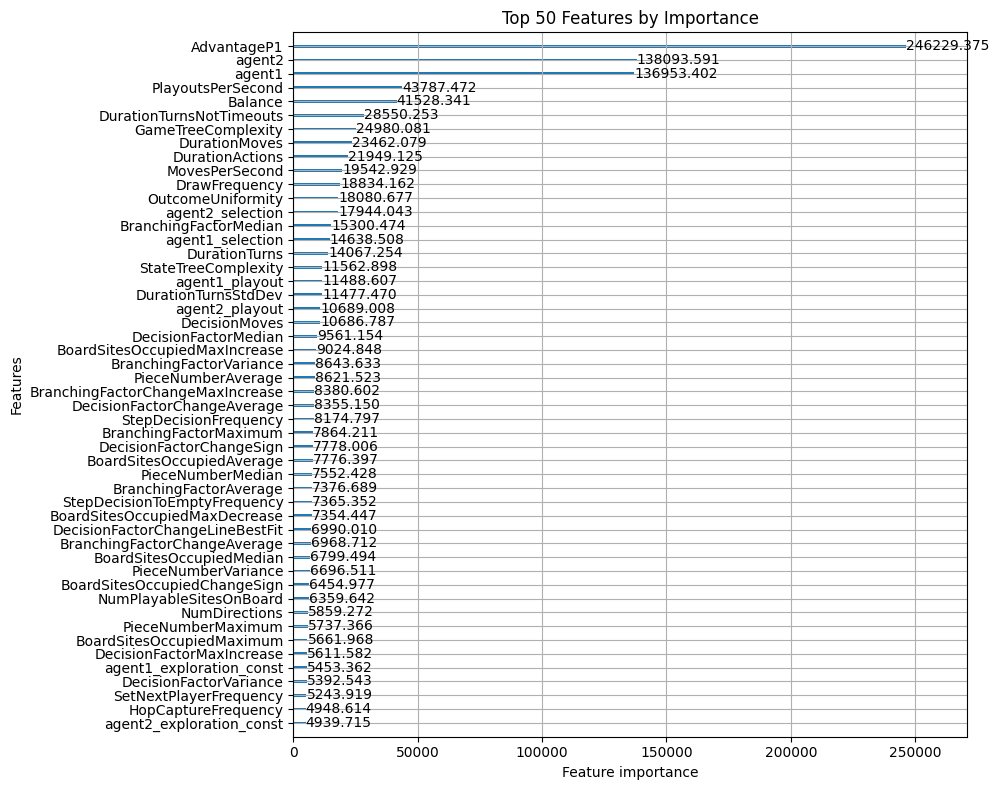

Fold 4 - RMSE: 0.41519900363501877
Fold 5


[100]	valid_0's rmse: 0.512835


[200]	valid_0's rmse: 0.491152


[300]	valid_0's rmse: 0.480244


[400]	valid_0's rmse: 0.473233


[500]	valid_0's rmse: 0.467765


[600]	valid_0's rmse: 0.462825


[700]	valid_0's rmse: 0.458991


[800]	valid_0's rmse: 0.456416


[900]	valid_0's rmse: 0.454005


[1000]	valid_0's rmse: 0.452012


[1100]	valid_0's rmse: 0.450264


[1200]	valid_0's rmse: 0.448245


[1300]	valid_0's rmse: 0.446915


[1400]	valid_0's rmse: 0.445921


[1500]	valid_0's rmse: 0.444779


[1600]	valid_0's rmse: 0.443937


[1700]	valid_0's rmse: 0.443193


[1800]	valid_0's rmse: 0.442568


[1900]	valid_0's rmse: 0.441771


[2000]	valid_0's rmse: 0.441134


[2100]	valid_0's rmse: 0.440576


[2200]	valid_0's rmse: 0.439949


[2300]	valid_0's rmse: 0.439512


[2400]	valid_0's rmse: 0.439182


[2500]	valid_0's rmse: 0.438732


[2600]	valid_0's rmse: 0.438317


[2700]	valid_0's rmse: 0.438066


[2800]	valid_0's rmse: 0.43786


[2900]	valid_0's rmse: 0.437525


[3000]	valid_0's rmse: 0.437216


[3100]	valid_0's rmse: 0.436761


[3200]	valid_0's rmse: 0.43652


[3300]	valid_0's rmse: 0.43625


[3400]	valid_0's rmse: 0.436003


[3500]	valid_0's rmse: 0.435659


[3600]	valid_0's rmse: 0.435447


[3700]	valid_0's rmse: 0.435242


[3800]	valid_0's rmse: 0.435003


[3900]	valid_0's rmse: 0.43483


[4000]	valid_0's rmse: 0.434742


[4100]	valid_0's rmse: 0.434603


[4200]	valid_0's rmse: 0.43437


[4300]	valid_0's rmse: 0.434102


[4400]	valid_0's rmse: 0.433981


[4500]	valid_0's rmse: 0.433895


[4600]	valid_0's rmse: 0.433726


[4700]	valid_0's rmse: 0.433478


[4800]	valid_0's rmse: 0.433375


[4900]	valid_0's rmse: 0.433326


[5000]	valid_0's rmse: 0.433231


[5100]	valid_0's rmse: 0.433132


[5200]	valid_0's rmse: 0.433033


[5300]	valid_0's rmse: 0.432922


[5400]	valid_0's rmse: 0.432817


[5500]	valid_0's rmse: 0.432712


[5600]	valid_0's rmse: 0.432625


[5700]	valid_0's rmse: 0.432587


[5800]	valid_0's rmse: 0.432501


[5900]	valid_0's rmse: 0.432468


[6000]	valid_0's rmse: 0.432459


[6100]	valid_0's rmse: 0.432432


[6200]	valid_0's rmse: 0.432294


[6300]	valid_0's rmse: 0.432268


[6400]	valid_0's rmse: 0.432162


[6500]	valid_0's rmse: 0.432126


[6600]	valid_0's rmse: 0.43206


[6700]	valid_0's rmse: 0.432025


[6800]	valid_0's rmse: 0.432022


[6900]	valid_0's rmse: 0.431955


[7000]	valid_0's rmse: 0.431913


[7100]	valid_0's rmse: 0.431824


[7200]	valid_0's rmse: 0.431771


[7300]	valid_0's rmse: 0.43176


[7400]	valid_0's rmse: 0.431747


[7500]	valid_0's rmse: 0.431705


[7600]	valid_0's rmse: 0.431575


[7700]	valid_0's rmse: 0.431543


[7800]	valid_0's rmse: 0.431501


[7900]	valid_0's rmse: 0.431452


[8000]	valid_0's rmse: 0.431398


[8100]	valid_0's rmse: 0.431321


[8200]	valid_0's rmse: 0.431354


[8300]	valid_0's rmse: 0.431273


[8400]	valid_0's rmse: 0.431297


[8500]	valid_0's rmse: 0.431222


[8600]	valid_0's rmse: 0.431167


[8700]	valid_0's rmse: 0.431131


[8800]	valid_0's rmse: 0.431172


[8900]	valid_0's rmse: 0.431149


[9000]	valid_0's rmse: 0.431127


[9100]	valid_0's rmse: 0.431131


[9200]	valid_0's rmse: 0.431142


[9300]	valid_0's rmse: 0.431062


[9400]	valid_0's rmse: 0.431004


[9500]	valid_0's rmse: 0.430982


[9600]	valid_0's rmse: 0.430966


[9700]	valid_0's rmse: 0.430899


[9800]	valid_0's rmse: 0.430915


[9900]	valid_0's rmse: 0.430924


[10000]	valid_0's rmse: 0.430874


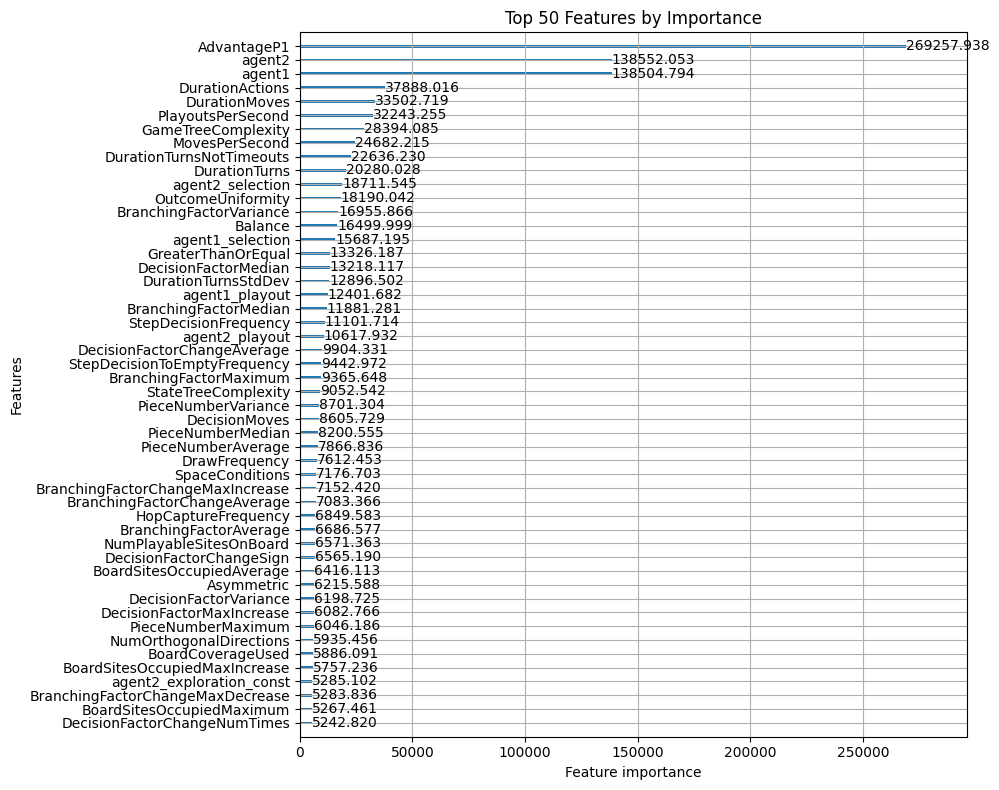

Fold 5 - RMSE: 0.4303695246545099
List of oof scores: [0.43460173532810337, 0.41286886521910343, 0.4261046050115251, 0.41519900363501877, 0.4303695246545099]
Average oof score: 0.4238287467696521


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4302
Score: 0.4526
Score: 0.4378
Score: 0.4375
Score: 0.4083
Average CV1 Score: 0.4333

CV2 OOF Scores:
Score: 0.4135
Score: 0.4049
Score: 0.4384
Score: 0.4421
Score: 0.4313
Average CV2 Score: 0.4260

CV3 OOF Scores:
Score: 0.4346
Score: 0.4129
Score: 0.4261
Score: 0.4152
Score: 0.4304
Average CV3 Score: 0.4238


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

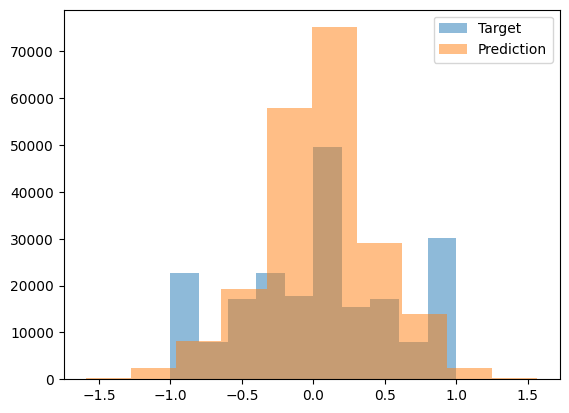

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.130009       │
│ 233235 ┆ -0.193337      │
│ 233236 ┆ -0.02118       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***